# Analysis of the floe size distribution
The Ice Floe Tracker (IFT) identifies sea ice floes in optical satellite images. Challenges to floe observation include cloud cover, indistinct floe boundaries, and floe sizes at or below the imager resolution. As a result of these challenges the floes identified by the IFT represent a sample of available floes. Nevertheless, the sample is large enough across the years to get a picture of FSD seasonality and to investigate the form of the distribution.

## 1. Choosing parameters for the FSD fit

# Clauset et al. analysis of the significance of the FSD fits
Box 1 in Clauset et al. 2009 contains a "recipe" for analysis of power-law data.
1. Estimate parameters $x_{min}$ and $\alpha$ of the power-law model using the methods in section 3.
2. Calculate the goodness-of-fit between the data and the power law using the method of section 4. If the resulting $p$-value is greater than 0.1, then a power law is a plausible hypothesis for the data, otherwise it is rejected.
3. Compare the power law with alternative hypothesis via likelihood ratio tests. For each alternative, if the calculated likelihood ratio is significantly different from zero, then its sign indicates whether or not the alternative is favored over the power-law model.

The method of minimizing the KS statistic is recommended by Clauset et al. Since we are estimating the $x_{min}$ across many individual instances, our approach is to find the value of $x_{min}$ that minimizes the KS distance in a random sample. Our sample sizes per image are much smaller than the 1000 samples that Clauset et al. recommends, so we expect more noise in the estimates. From the KS tests, the fit is not very sensitive to the exact value of x-min, but if it is less than about 35 km$^2$ the performance degrades rapidly. There is less of a change in fit quality as the value goes above 41 km$^2$.

To estimate the p-value of the fit, we can use a bootstrap approach. The method is to take the parameters of the fitted distribution, then to draw random samples to estimate the distribution of the KS statistics. Then, the p-value of the KS statistic for the real data can be estimated by calculating the fraction of the simulated data with KS statistics larger than the real data. The powerlaw package has a built in function to generate a random sample following the same distribution as a fitted value. They suggest a sample size of 2500 for computing p-values with accuracy of 0.01. 

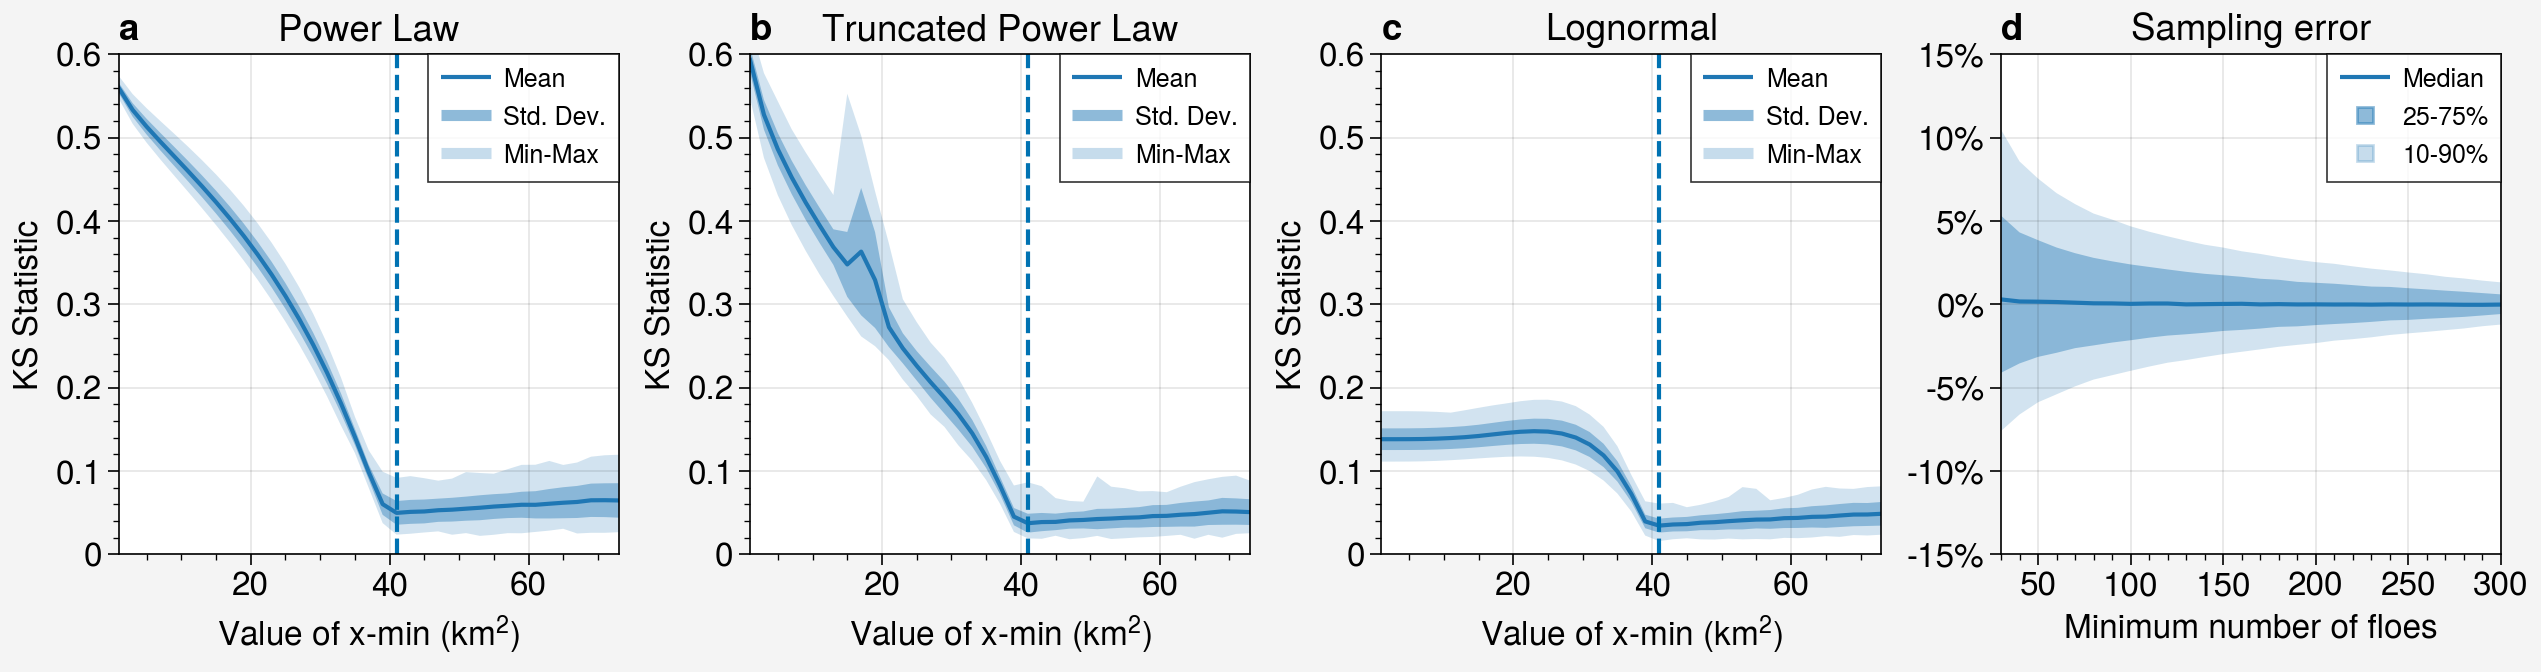

In [1]:
%run ../scripts/plot_fig_06_fsd_min_floe_test.py

Panels a-c show that the choice of 41 km$^2$ minimizes the difference betweeen the empirical and parametric distributions. Panel d shows the relative error in estimating the FSD slope parameter based on taking a bootstrap subsample of the floes in an image. In our dataset 732 images have more than 300 detected floes. Understanding the IFT results as a sample from the full set of ice floes, we test the minimum number of floes required to recover the power law slope of the full image. We test thresholds from 30 up to 300 floes and take 100 samples without replacement for each threshold size. We calculate the alpha parameter for each subsample and compute the relative error against the fit with all detected floes in the image. The test is carried out on a random sample of 100 of the 732 images.

Supporting calculation scripts:
* calculate_fsd_parameters_uncertainty.py


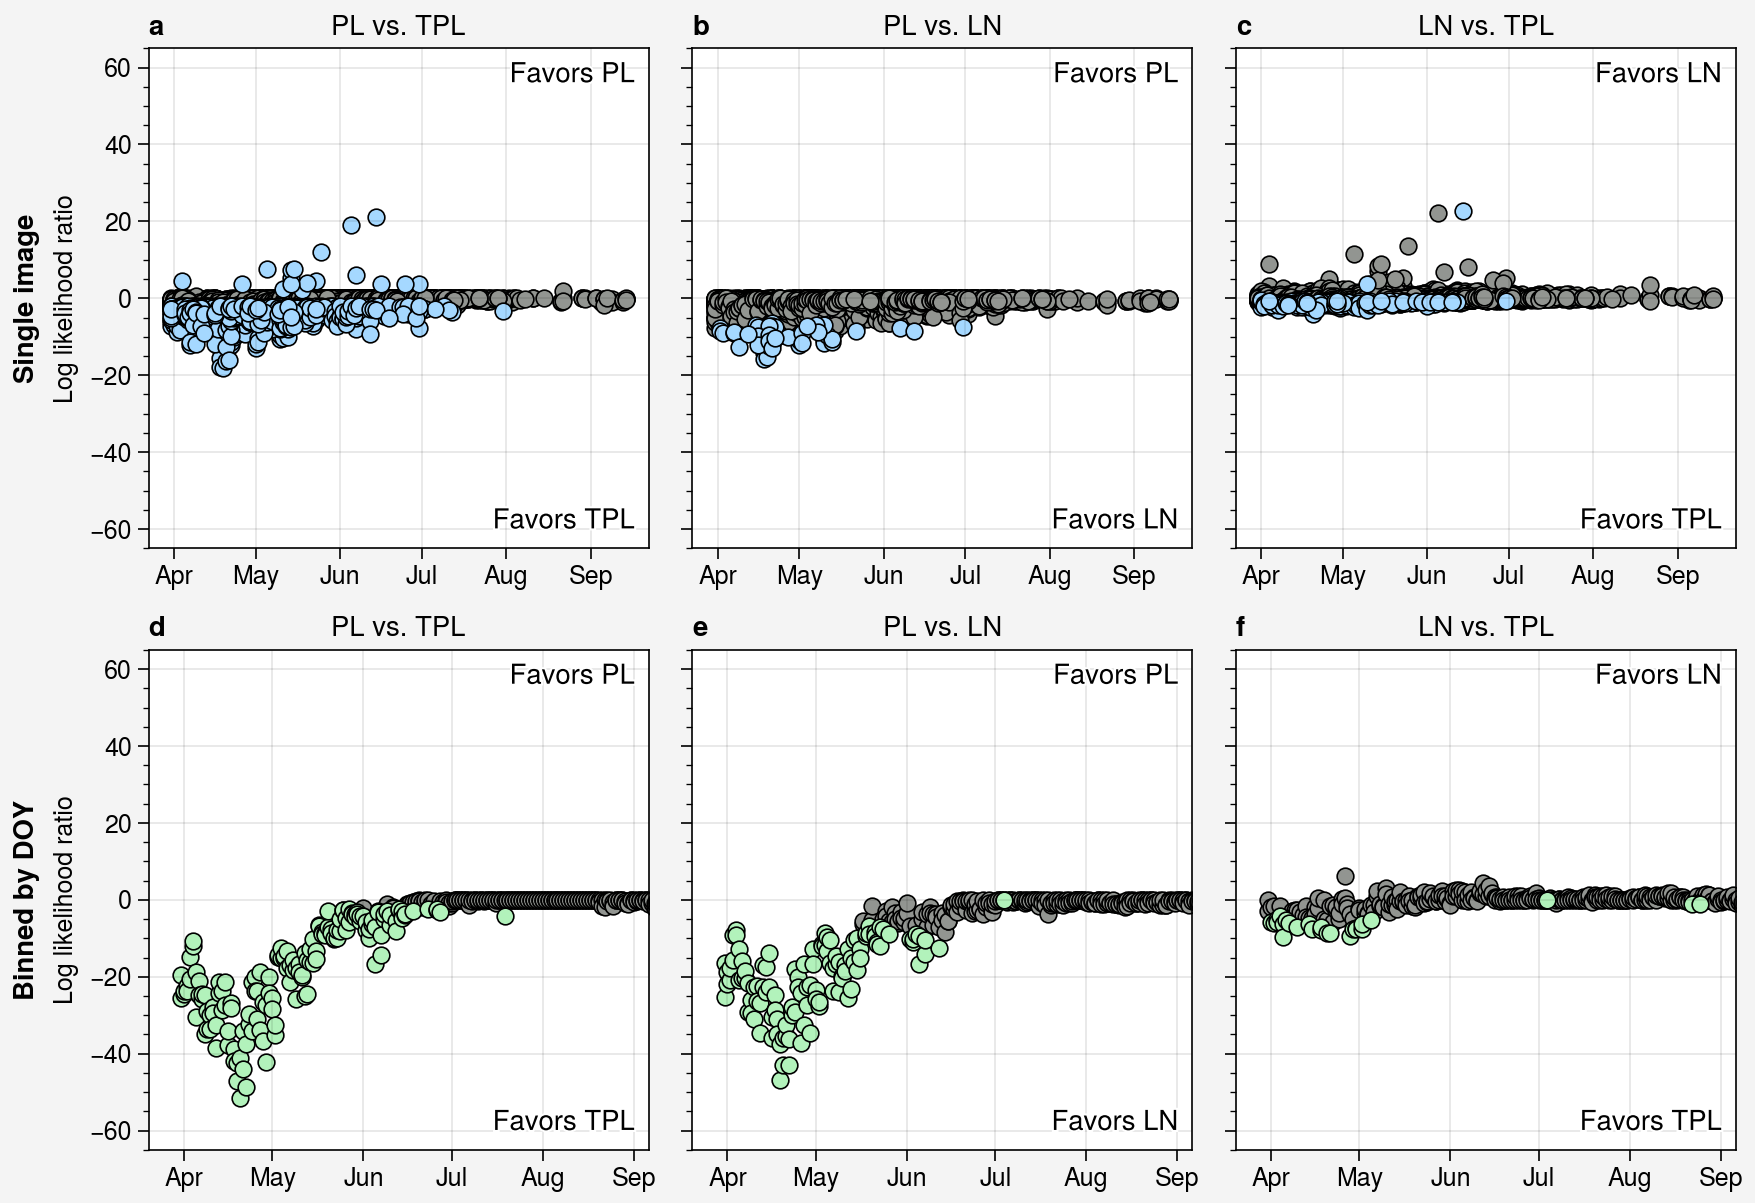

In [2]:
%run ../scripts/plot_fig_08_fsd_likelihood_test.py

This figure shows the results of a likelihood ratio test for the three distributions under consideration.
We tend to get significant results early in the season, with the truncated power law distribution favored over the power law and slightly favored over the lognormal distribution. Later in the season, with fewer data points, we can't say any distribution is better than any other. Not shown: the parameters of the best fit lognormal distribution become erratic after approximately July 1, suggesting that the distribution is not a good choice for late season FSD. 

### False discovery rate procedure for multiple hypothesis testing (Bejamini-Hochberg procedure).
The colors show significance after adjusting for the false discovery rate. Here's how it works.
Sort the $p$ values for all tests, so the $p_k$ is the $k$th largest $p$ value. Let $m$ be the number of tests. Then for significance level $\alpha$, we consider all tests with 
$$P_k \leq \frac km \alpha$$
to be statistically significant. 



## Year-to-year variability from randomly sampled dates

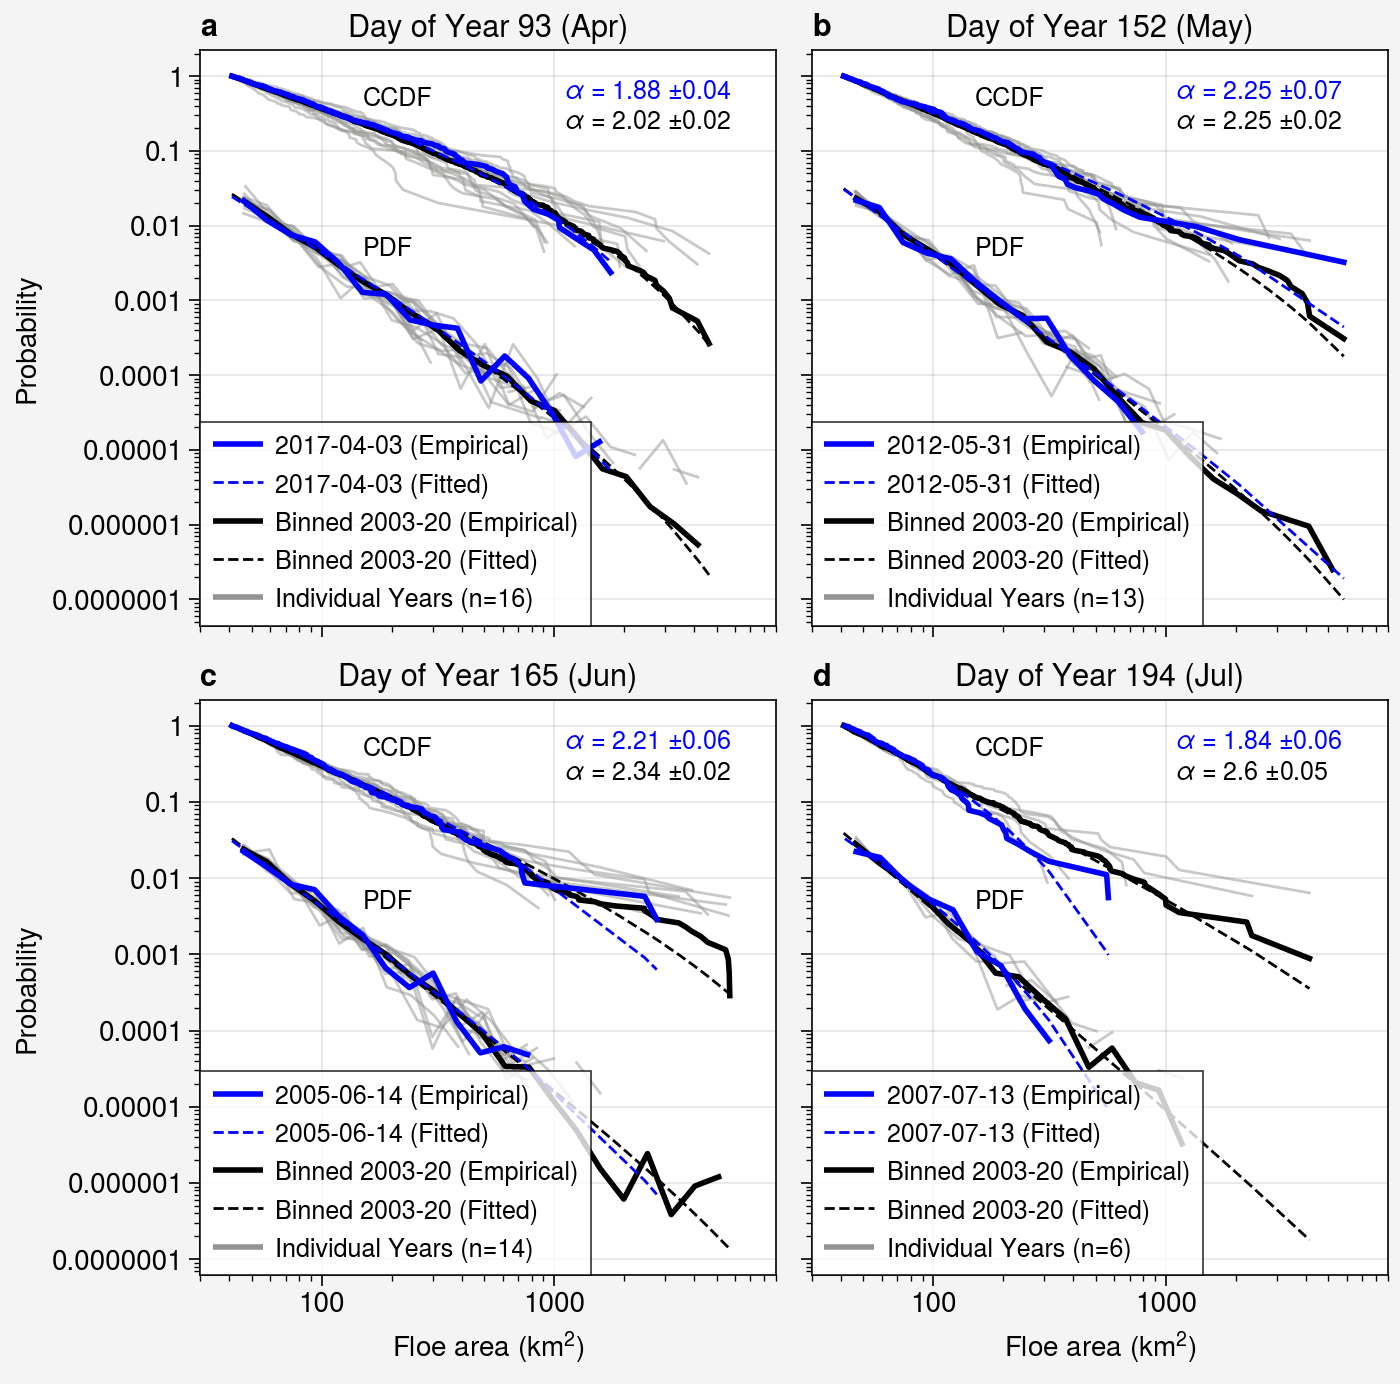

In [4]:
%run ../scripts/plot_fig_09_fsd_examples.py

Some alternate ideas:
* breaking it up by edge distance & coast distance
* pooling by day of year beofre calculating fit

# Seasonality in the MIZ
Update figure 10: Power law slope (all data), power law slope binned by DOY and separated by SIC.

Add figure with the sea ice extent and MIZ fraction

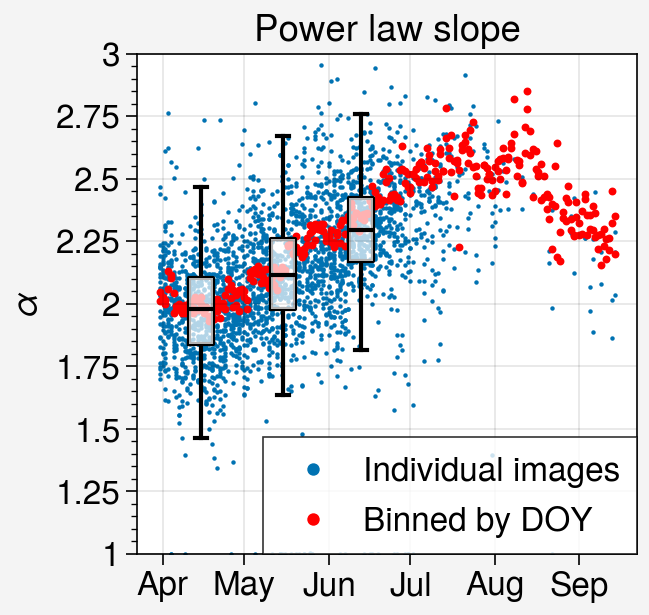

In [16]:
%run ../scripts/plot_fig_12_fsd_seasonality.py

# Compute fits for MIZ vs pack ice

In [113]:
floe_lib_clean = {}
for file in os.listdir('../data/floe_tracker/ift_floe_property_tables/with_nsidc/'):
    if 'csv' in file: 
        year = int(file.replace('.csv', '').split('_')[-1])
        floe_lib_clean[year] = pd.read_csv('../data/floe_tracker/ift_floe_property_tables/with_nsidc/' + file,
                                         index_col=0, dtype={'classification': str})
        floe_lib_clean[year]['datetime'] = pd.to_datetime(floe_lib_clean[year]['datetime'])

df = pd.concat(floe_lib_clean).reset_index()
df = df.loc[(df.datetime.dt.dayofyear >= 91) & (df.datetime.dt.dayofyear <= 258)]

df['perim_km'] = df.perimeter*.25
df['area_km'] = df.area*.25*.25
df['area_adj_km'] = (np.sqrt(df.area) + 8)**2*.25*.25 # Pixel shift minimizes error against manual
df['doy'] = df.datetime.dt.dayofyear
df['year'] = df.datetime.dt.year


In [9]:
import pandas as pd
import numpy as np
import powerlaw
import os

n_threshold = 100
miz_results = []
pack_results = []
x_min = 41
df['doy'] = df.datetime.dt.dayofyear

for results, idx_sel in zip([miz_results, pack_results],
                            [df.nsidc_sic.between(0.15, 0.85),
                             df.nsidc_sic.between(0.85, 1.0)]):
    for doy, df_doy in df.loc[idx_sel, :].groupby('doy'):
        for satellite, group in df_doy.groupby('satellite'):
            if len(group.loc[group.area_adj_km > x_min]) > n_threshold:
                area = group.area_adj_km
                fit = powerlaw.Fit(area, xmin=x_min, verbose=False)
                results.append([doy, satellite, len(df_doy),
                                    fit.power_law.alpha,
                                    fit.truncated_power_law.alpha,
                                    fit.truncated_power_law.parameter2,
                                    fit.power_law.D,
                                    fit.truncated_power_law.D
                                ])

In [10]:
miz_results = pd.DataFrame(miz_results, columns=['doy', 'satellite', 'n',
                                         'alpha', 'alpha_tpl', 'lambda_tpl',
                                         'D_PL', 'D_TPL'])        
miz_results['month'] = (pd.to_datetime('2001-01-01') + pd.to_timedelta(miz_results.doy, 'D')).dt.month      
miz_results['month'] = (pd.to_datetime('2001-01-01') + pd.to_timedelta(miz_results.doy, 'D')).dt.month
    # results_alt.to_csv(saveloc + 'ift_fsd_table_all_years_by_DOY.csv')

In [11]:
pack_results = pd.DataFrame(pack_results, columns=['doy', 'satellite', 'n',
                                         'alpha', 'alpha_tpl', 'lambda_tpl',
                                         'D_PL', 'D_TPL'])        
pack_results['month'] = (pd.to_datetime('2001-01-01') + pd.to_timedelta(pack_results.doy, 'D')).dt.month      
pack_results['month'] = (pd.to_datetime('2001-01-01') + pd.to_timedelta(pack_results.doy, 'D')).dt.month


In [115]:
%%time
n_threshold = 100
edge_results = []
coast_results = []
x_min = 41
df['doy'] = df.datetime.dt.dayofyear

for results, idx_sel in zip([edge_results, coast_results],
                            [df.edge_dist_km.between(0, 100),
                             df.coast_dist_km.between(0, 100)]):
    for doy, df_doy in df.loc[idx_sel, :].groupby('doy'):
        for satellite, group in df_doy.groupby('satellite'):
            if len(group.loc[group.area_adj_km > x_min]) > n_threshold:
                area = group.area_adj_km
                fit = powerlaw.Fit(area, xmin=x_min, verbose=False)
                results.append([doy, satellite, len(df_doy),
                                    fit.power_law.alpha,
                                    fit.truncated_power_law.alpha,
                                    fit.truncated_power_law.parameter2,
                                    fit.power_law.D,
                                    fit.truncated_power_law.D
                                ])
edge_results = pd.DataFrame(edge_results, columns=['doy', 'satellite', 'n',
                                         'alpha', 'alpha_tpl', 'lambda_tpl',
                                         'D_PL', 'D_TPL'])        
edge_results['month'] = (pd.to_datetime('2001-01-01') + pd.to_timedelta(edge_results.doy, 'D')).dt.month      
edge_results['month'] = (pd.to_datetime('2001-01-01') + pd.to_timedelta(edge_results.doy, 'D')).dt.month

coast_results = pd.DataFrame(coast_results, columns=['doy', 'satellite', 'n',
                                         'alpha', 'alpha_tpl', 'lambda_tpl',
                                         'D_PL', 'D_TPL'])        
coast_results['month'] = (pd.to_datetime('2001-01-01') + pd.to_timedelta(coast_results.doy, 'D')).dt.month      
coast_results['month'] = (pd.to_datetime('2001-01-01') + pd.to_timedelta(coast_results.doy, 'D')).dt.month


CPU times: user 26.6 s, sys: 58 ms, total: 26.6 s
Wall time: 26.6 s


In [86]:
df_pivot = df_pivot[month_idx].copy()
df_pivot.columns =  t(doy[month_idx].values)


In [ ]:
dr = pd.date_range('2020-04-01', '2020-12-01', freq='1MS')
t = lambda doy:  pd.to_datetime('2020-01-01 00:00') + pd.to_timedelta(doy, unit='day')

fig, axs =pplt.subplots(ncols=2, nrows=1, share=False) 
ax = axs[0]
n_threshold = 1 # check what this one is doing -- is it just to see if the month has anything in it?
month_threshold = 300
variable = 'alpha_tpl'
time_idx = (results.month != 3) & (results.month <= 9)
df_pivot = results.loc[time_idx & (results.n > n_threshold)].pivot_table(index='date', values=variable, columns='month')
month_counts = df_pivot.notnull().sum() 
month_idx = [m for m in month_counts.index if month_counts[m] > month_threshold]
df_pivot = df_pivot[month_idx].copy()
df_pivot.columns =  t(doy[month_idx].values)
# _ = ax.box(df_pivot, facecolor='w', alpha=0.7, zorder=1, lw=1.5, marker='')
df_pivot.T.boxplot(ax=ax)
_ = ax.scatter(t(results.loc[results.n > n_threshold].date.dt.dayofyear),
               results.loc[results.n > n_threshold, variable], marker='o', ms=1, zorder=0, label='Individual images')
_ = ax.scatter(t(results_alt.doy), results_alt[variable], marker='o', ms=5, zorder=0, color='r', label='Binned by DOY')
ax.format(ylim=(1, 3), 
          xformatter='%b',
           abc=True, xlabel='', ylabel='$\\alpha$', fontsize=12, xrotation=45)
ax.legend(loc='lr', ncols=1, ms=15, fontsize=12)

ax = axs[1]
_ = ax.scatter(t(miz_results.doy), miz_results[variable].values, marker='o', ms=5, zorder=0, color='slateblue', label='Pack Ice')
_ = ax.scatter(t(pack_results.doy), pack_results[variable].values, marker='o', ms=5, zorder=0, color='tab:green', label='MIZ')

ax.legend(loc='lr', ncols=1, ms=15, fontsize=12)
ax.format(xformatter='%b', xrotation=45, ylim=(1.25, 3),
          xlabel='', ylabel='$\\alpha$', xtickminor=False, fontsize=12, abc=True)

In [121]:
# Load FSD Data
results = []
for year in range(2003, 2021):
    results.append(pd.read_csv('../data/floe_tracker/ift_fsd_tables/ift_fsd_table_{y}.csv'.format(y=year), parse_dates=['date']))
results = pd.concat(results, axis=0)
results_alt = pd.read_csv('../data/floe_tracker/ift_fsd_tables/ift_fsd_table_all_years_by_DOY.csv')
doy = results.groupby('month').mean()['doy']


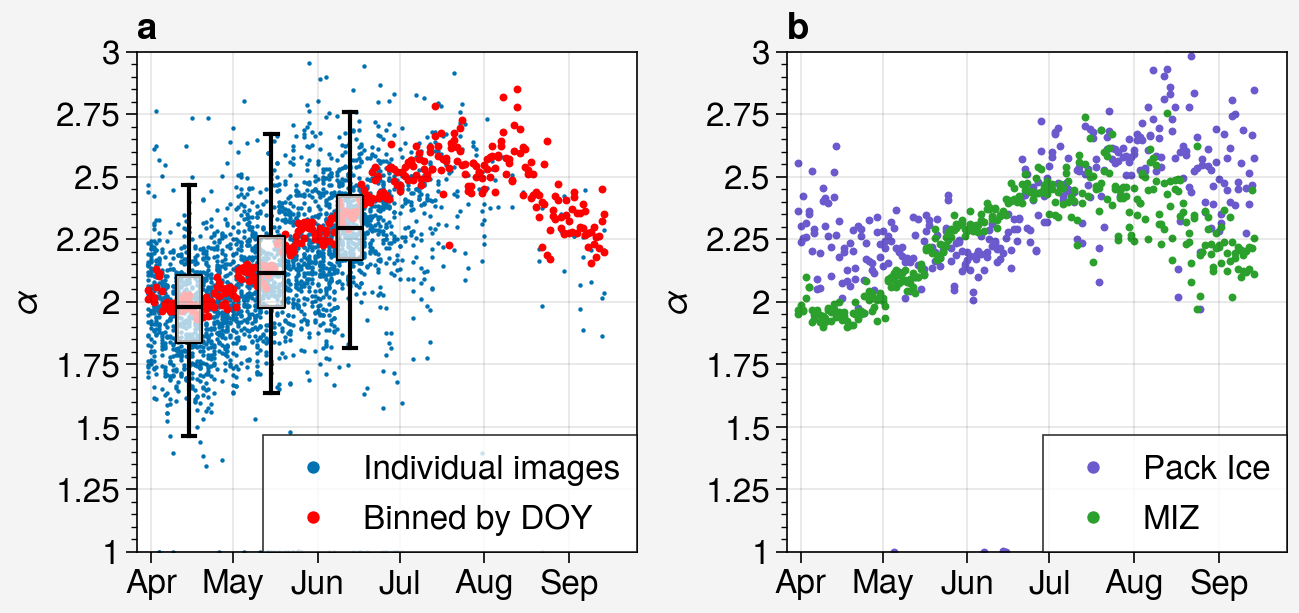

In [122]:
dr = pd.date_range('2020-04-01', '2020-12-01', freq='1MS')

fig, axs =pplt.subplots(ncols=2, nrows=1, share=False) 
ax = axs[0]
n_threshold = 1 # check what this one is doing -- is it just to see if the month has anything in it?
month_threshold = 300
variable = 'alpha_tpl'
time_idx = (results.month != 3) & (results.month <= 9)
df_pivot = results.loc[time_idx & (results.n > n_threshold)].pivot_table(index='date', values=variable, columns='month')
month_counts = df_pivot.notnull().sum() 
month_idx = [m for m in month_counts.index if month_counts[m] > month_threshold]
_ = ax.box(doy[month_idx].values/30, df_pivot[month_idx], facecolor='w', alpha=0.7, zorder=1, lw=1.5, marker='')
_ = ax.scatter(results.loc[results.n > n_threshold].date.dt.dayofyear/30,
               results.loc[results.n > n_threshold, variable], marker='o', ms=1, zorder=0, label='Individual images')
_ = ax.scatter(results_alt.doy/30, results_alt[variable], marker='o', ms=5, zorder=0, color='r', label='Binned by DOY')
ax.legend(loc='lr', ncols=1, ms=15, fontsize=12)

ax = axs[1]
_ = ax.scatter(miz_results.doy/30, miz_results[variable].values, marker='o', ms=5, zorder=0, color='slateblue', label='Pack Ice')
_ = ax.scatter(pack_results.doy/30, pack_results[variable].values, marker='o', ms=5, zorder=0, color='tab:green', label='MIZ')

ax.legend(loc='lr', ncols=1, ms=15, fontsize=12)
for ax in axs:
    ax.format(ylim=(1, 3), xlocator=dr.dayofyear/30, xlim=(2.9, 9),
              xformatter=[d.strftime('%b') for d in dr],
               abc=True, xlabel='', ylabel='$\\alpha$', fontsize=12, xrotation=0)

How can we 

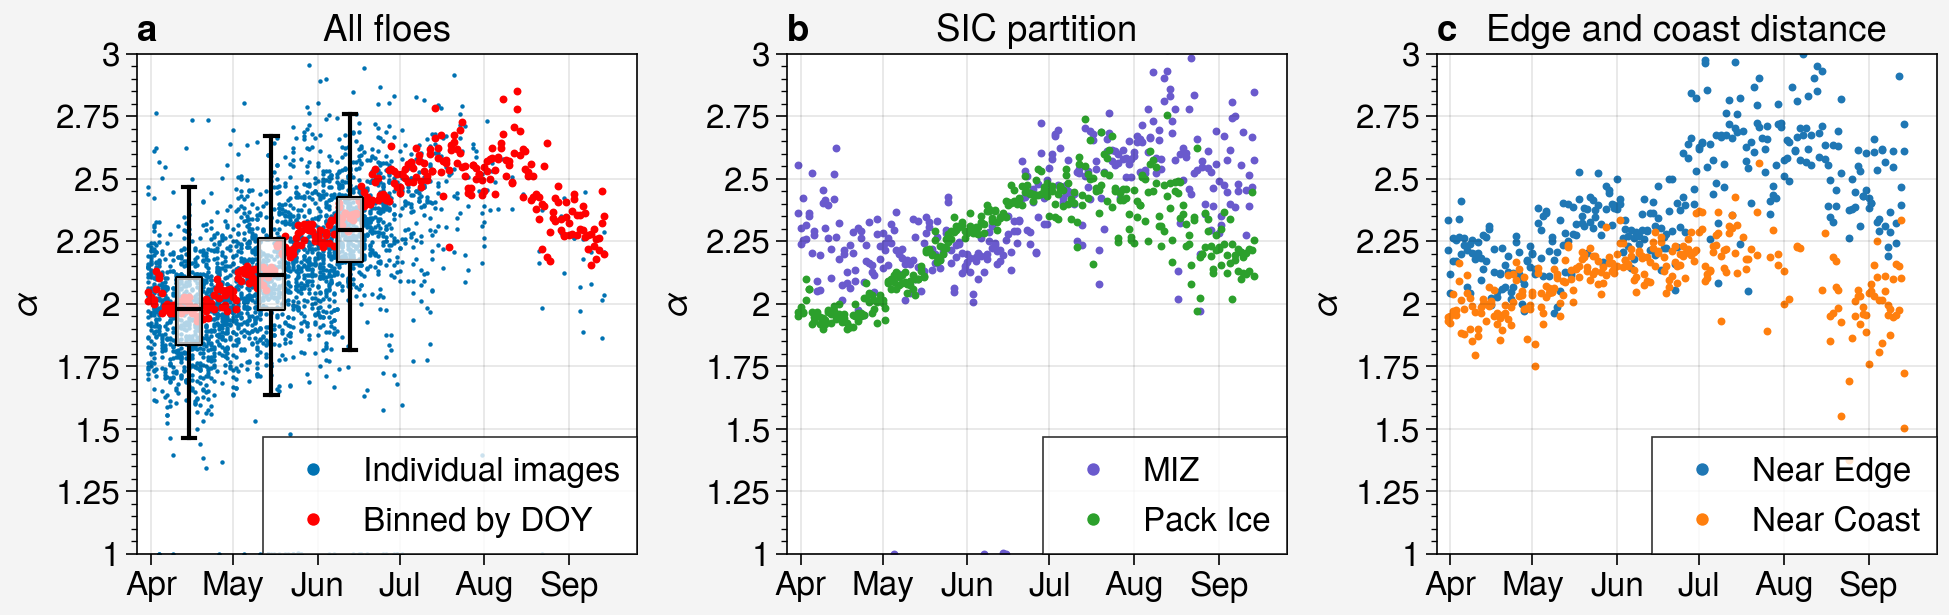

In [150]:
fig, axs =pplt.subplots(ncols=3, nrows=1, share=False) 
ax = axs[0]
n_threshold = 1 # check what this one is doing -- is it just to see if the month has anything in it?
month_threshold = 300
variable = 'alpha_tpl'
time_idx = (results.month != 3) & (results.month <= 9)
df_pivot = results.loc[time_idx & (results.n > n_threshold)].pivot_table(index='date', values=variable, columns='month')
month_counts = df_pivot.notnull().sum() 
month_idx = [m for m in month_counts.index if month_counts[m] > month_threshold]
_ = ax.box(doy[month_idx].values/30, df_pivot[month_idx], facecolor='w', alpha=0.7, zorder=1, lw=1.5, marker='')
_ = ax.scatter(results.loc[results.n > n_threshold].date.dt.dayofyear/30,
               results.loc[results.n > n_threshold, variable], marker='o', ms=1, zorder=0, label='Individual images')
_ = ax.scatter(results_alt.doy/30, results_alt[variable], marker='o', ms=5, zorder=0, color='r', label='Binned by DOY')
ax.legend(loc='lr', ncols=1, ms=15, fontsize=12)

ax = axs[1]
_ = ax.scatter(miz_results.doy/30, miz_results[variable].values, marker='o', ms=5, zorder=0, color='slateblue', label='MIZ')
_ = ax.scatter(pack_results.doy/30, pack_results[variable].values, marker='o', ms=5, zorder=0, color='tab:green', label='Pack Ice')

ax.legend(loc='lr', ncols=1, ms=15, fontsize=12)
for ax in axs:
    ax.format(ylim=(1, 3), xlocator=dr.dayofyear/30, xlim=(2.9, 9),
              xformatter=[d.strftime('%b') for d in dr],
               abc=True, xlabel='', ylabel='$\\alpha$', fontsize=12, xrotation=0)

ax = axs[2]
_ = ax.scatter(edge_results.doy/30, edge_results[variable].values, marker='o', ms=5, zorder=0, color='tab:blue', label='Near Edge')
_ = ax.scatter(coast_results.doy/30, coast_results[variable].values, marker='o', ms=5, zorder=0, color='tab:orange', label='Near Coast')

ax.legend(loc='lr', ncols=1, ms=15, fontsize=12)
for ax in axs:
    ax.format(ylim=(1, 3), xlocator=dr.dayofyear/30, xlim=(2.9, 9),
              xformatter=[d.strftime('%b') for d in dr],
               abc=True, xlabel='', ylabel='$\\alpha$', fontsize=12, xrotation=0)

axs[0].format(title='All floes')
axs[1].format(title='SIC partition')
axs[2].format(title='Edge and coast distance')
fig.save('../figures/fsd_seasonality_grouped.png', dpi=300)

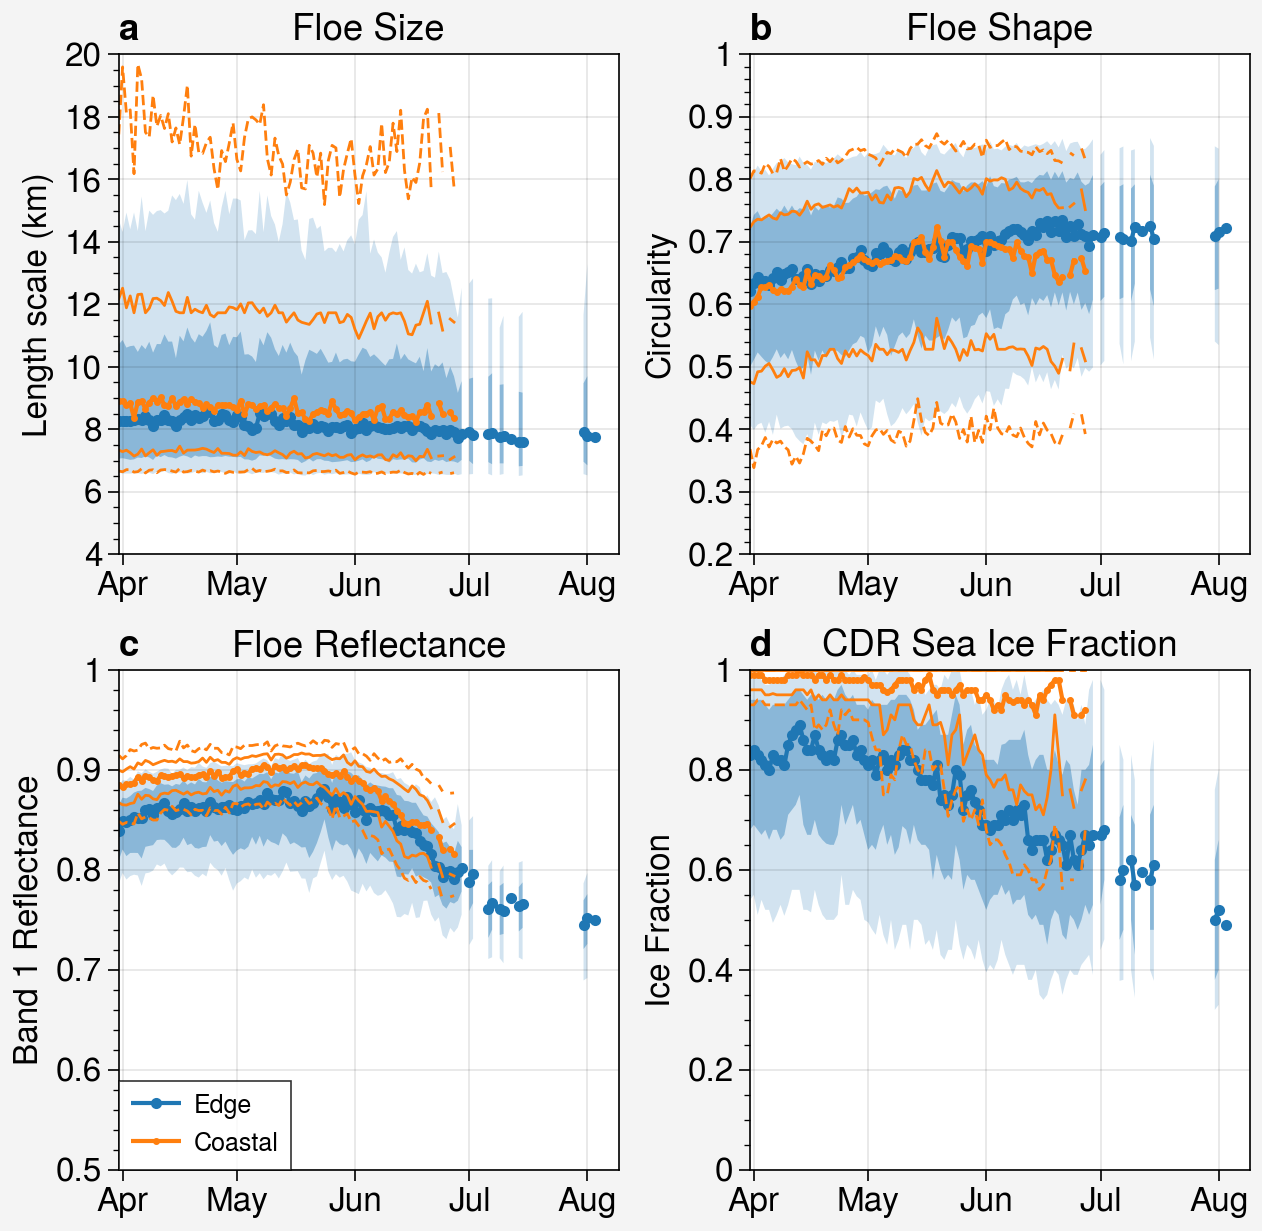

In [147]:
df['band_1_reflectance'] = df['tc_channel0']/255
df['month'] = df.datetime.dt.month
df['n'] = df.groupby('datetime').transform(lambda x: len(x))['area']
df['length_scale_km'] = df['area_adj_km']**0.5
fig, axs = pplt.subplots(ncols=2, share=False, nrows=2)
idx = df.n > 30
idx = idx & df.edge_dist_km.between(0, 100) & (df.coast_dist_km > 100)
idx = idx & df.final_classification
for col, var, ylims in zip([0, 1, 2, 3],
                          ['length_scale_km', 'circularity', 'band_1_reflectance', 'nsidc_sic'],
                          [(4, 20), (0.2, 1), (0.5, 1), (0, 1)]):
    # shade data
    ax = axs[col]
    n = df.loc[idx, [var, 'doy']].groupby('doy').count()
    med = df.loc[idx, [var, 'doy']].groupby('doy').median().where(n > 500)
    p90 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.90).where(n > 500)
    p10 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.10).where(n > 500)
    p75 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.75).where(n > 500)
    p25 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.25).where(n > 500)
    ax.plot(med[var], fadedata=[p90[var], p10[var]],
            shadedata=[p75[var], p25[var]], marker='.', color='tab:blue', label='Edge')
    ax.format(ylabel=var.replace('_', ' '),
              xlocator=dr.dayofyear,
              xformatter=[d.strftime('%b') for d in dr],
              xlabel='', fontsize=12, ylim=ylims)

idx = df.n > 30
idx = idx & df.coast_dist_km.between(0, 100) & (df.edge_dist_km > 100)
idx = idx & df.final_classification
for col, var, ylims in zip([0, 1, 2, 3],
                          ['length_scale_km', 'circularity', 'band_1_reflectance', 'nsidc_sic'],
                          [(4, 20), (0.2, 1), (0.5, 1), (0, 1)]):
    ax = axs[col]
    n = df.loc[idx, [var, 'doy']].groupby('doy').count()
    med = df.loc[idx, [var, 'doy']].groupby('doy').median().where(n > 500)
    p90 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.90).where(n > 500)
    p10 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.10).where(n > 500)
    p75 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.75).where(n > 500)
    p25 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.25).where(n > 500)
    
    # overlay lines
    ax.plot(med[var], marker='.', color='tab:orange', ms=3, label='Coastal')
    ax.plot(p75[var], ls='-', lw=1, color='tab:orange', label='')
    ax.plot(p25[var], ls='-', lw=1, color='tab:orange', label='')
    ax.plot(p90[var], ls='--', lw=1, color='tab:orange', label='')
    ax.plot(p10[var], ls='--', lw=1, color='tab:orange', label='')
    ax.format(ylabel=var.replace('_', ' '),
              xlocator=dr.dayofyear,
              xformatter=[d.strftime('%b') for d in dr],
              xlabel='', fontsize=12, ylim=ylims)
axs[0].format(ylabel='Length scale (km)', title='Floe Size')
axs[1].format(ylabel='Circularity', title='Floe Shape')
axs[2].format(ylabel='Band 1 Reflectance', title='Floe Reflectance')
axs[3].format(ylabel='Ice Fraction', title='CDR Sea Ice Fraction')

axs[2].legend(ncols=1, loc='ll')
axs.format(abc=True)
fig.save('../figures/floe_properties_seasonality_edge_v_coast.png', dpi=300)

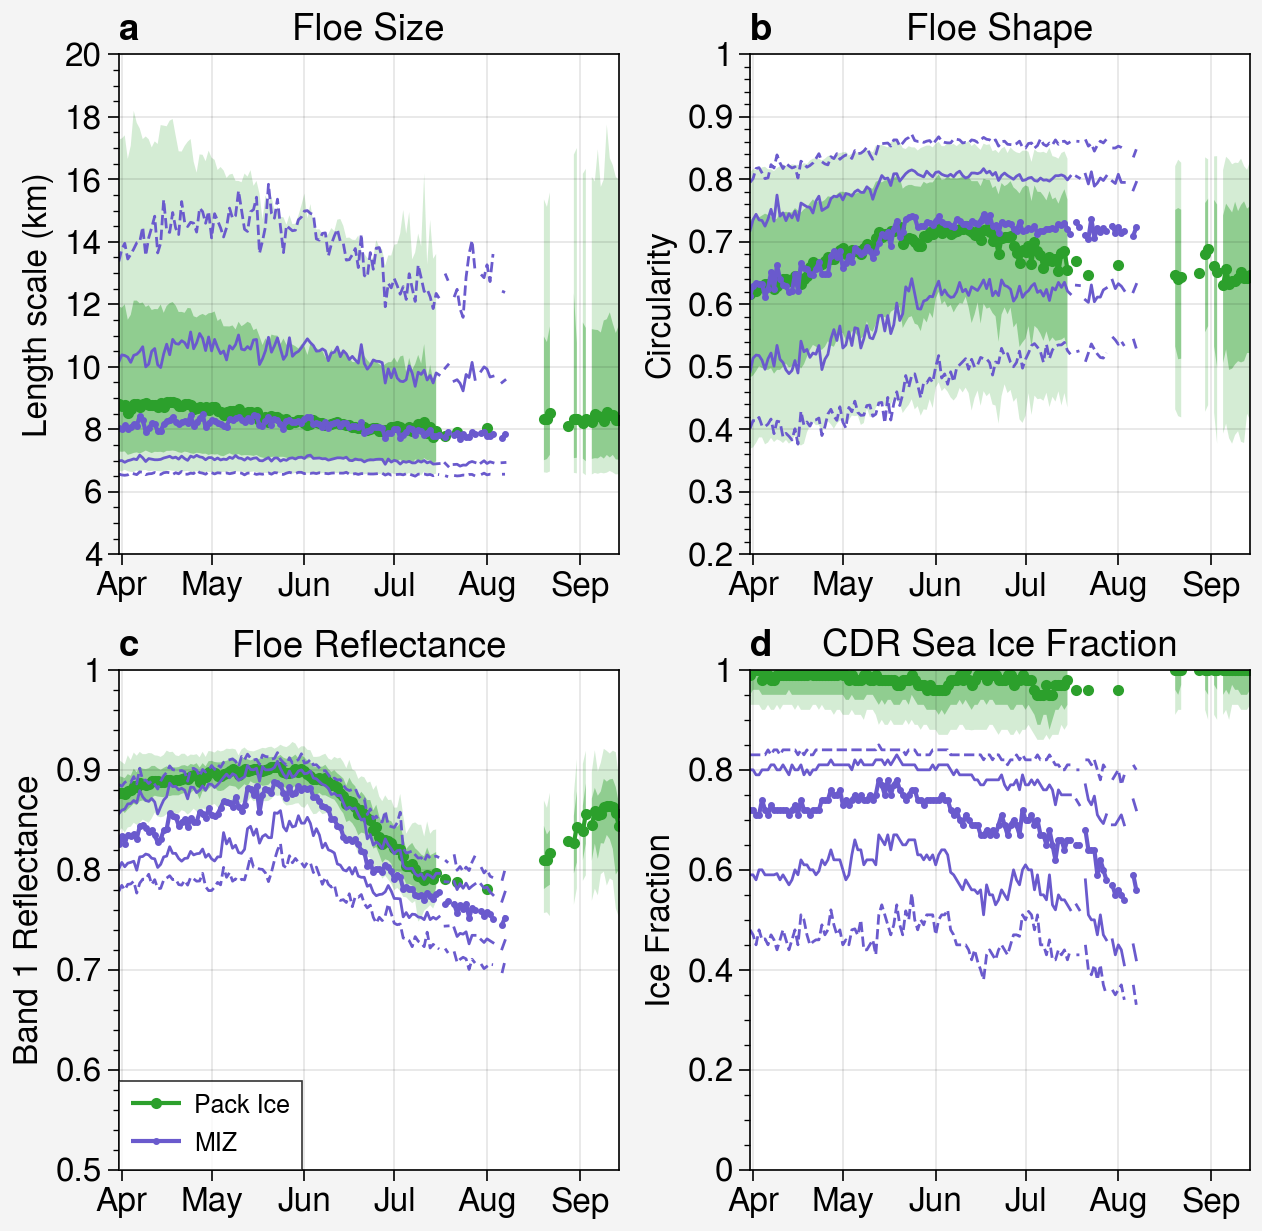

In [149]:
df['band_1_reflectance'] = df['tc_channel0']/255
df['month'] = df.datetime.dt.month
df['n'] = df.groupby('datetime').transform(lambda x: len(x))['area']
df['length_scale_km'] = df['area_adj_km']**0.5
fig, axs = pplt.subplots(ncols=2, share=False, nrows=2)
idx = df.n > 30
idx = idx & df.nsidc_sic.between(0.85, 1)
idx = idx & df.final_classification
for col, var, ylims in zip([0, 1, 2, 3],
                          ['length_scale_km', 'circularity', 'band_1_reflectance', 'nsidc_sic'],
                          [(4, 20), (0.2, 1), (0.5, 1), (0, 1)]):
    # shade data
    ax = axs[col]
    n = df.loc[idx, [var, 'doy']].groupby('doy').count()
    med = df.loc[idx, [var, 'doy']].groupby('doy').median().where(n > 500)
    p90 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.90).where(n > 500)
    p10 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.10).where(n > 500)
    p75 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.75).where(n > 500)
    p25 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.25).where(n > 500)
    ax.plot(med[var], fadedata=[p90[var], p10[var]],
            shadedata=[p75[var], p25[var]], marker='.', color='tab:green', label='Pack Ice')
    ax.format(ylabel=var.replace('_', ' '),
              xlocator=dr.dayofyear,
              xformatter=[d.strftime('%b') for d in dr],
              xlabel='', fontsize=12, ylim=ylims)

idx = df.n > 30
idx = idx & df.nsidc_sic.between(0.15, 0.85)
idx = idx & df.final_classification
for col, var, ylims in zip([0, 1, 2, 3],
                          ['length_scale_km', 'circularity', 'band_1_reflectance', 'nsidc_sic'],
                          [(4, 20), (0.2, 1), (0.5, 1), (0, 1)]):
    ax = axs[col]
    n = df.loc[idx, [var, 'doy']].groupby('doy').count()
    med = df.loc[idx, [var, 'doy']].groupby('doy').median().where(n > 500)
    p90 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.90).where(n > 500)
    p10 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.10).where(n > 500)
    p75 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.75).where(n > 500)
    p25 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.25).where(n > 500)
    
    # overlay lines
    c = 'slateblue'
    ax.plot(med[var], marker='.', color=c, ms=3, label='MIZ')
    ax.plot(p75[var], ls='-', lw=1, color=c, label='')
    ax.plot(p25[var], ls='-', lw=1, color=c, label='')
    ax.plot(p90[var], ls='--', lw=1, color=c, label='')
    ax.plot(p10[var], ls='--', lw=1, color=c, label='')
    ax.format(ylabel=var.replace('_', ' '),
              xlocator=dr.dayofyear,
              xformatter=[d.strftime('%b') for d in dr],
              xlabel='', fontsize=12, ylim=ylims)
axs[0].format(ylabel='Length scale (km)', title='Floe Size')
axs[1].format(ylabel='Circularity', title='Floe Shape')
axs[2].format(ylabel='Band 1 Reflectance', title='Floe Reflectance')
axs[3].format(ylabel='Ice Fraction', title='CDR Sea Ice Fraction')

axs[2].legend(ncols=1, loc='ll')
axs.format(abc=True)
fig.save('../figures/floe_properties_seasonality_pack_v_miz.png', dpi=300)

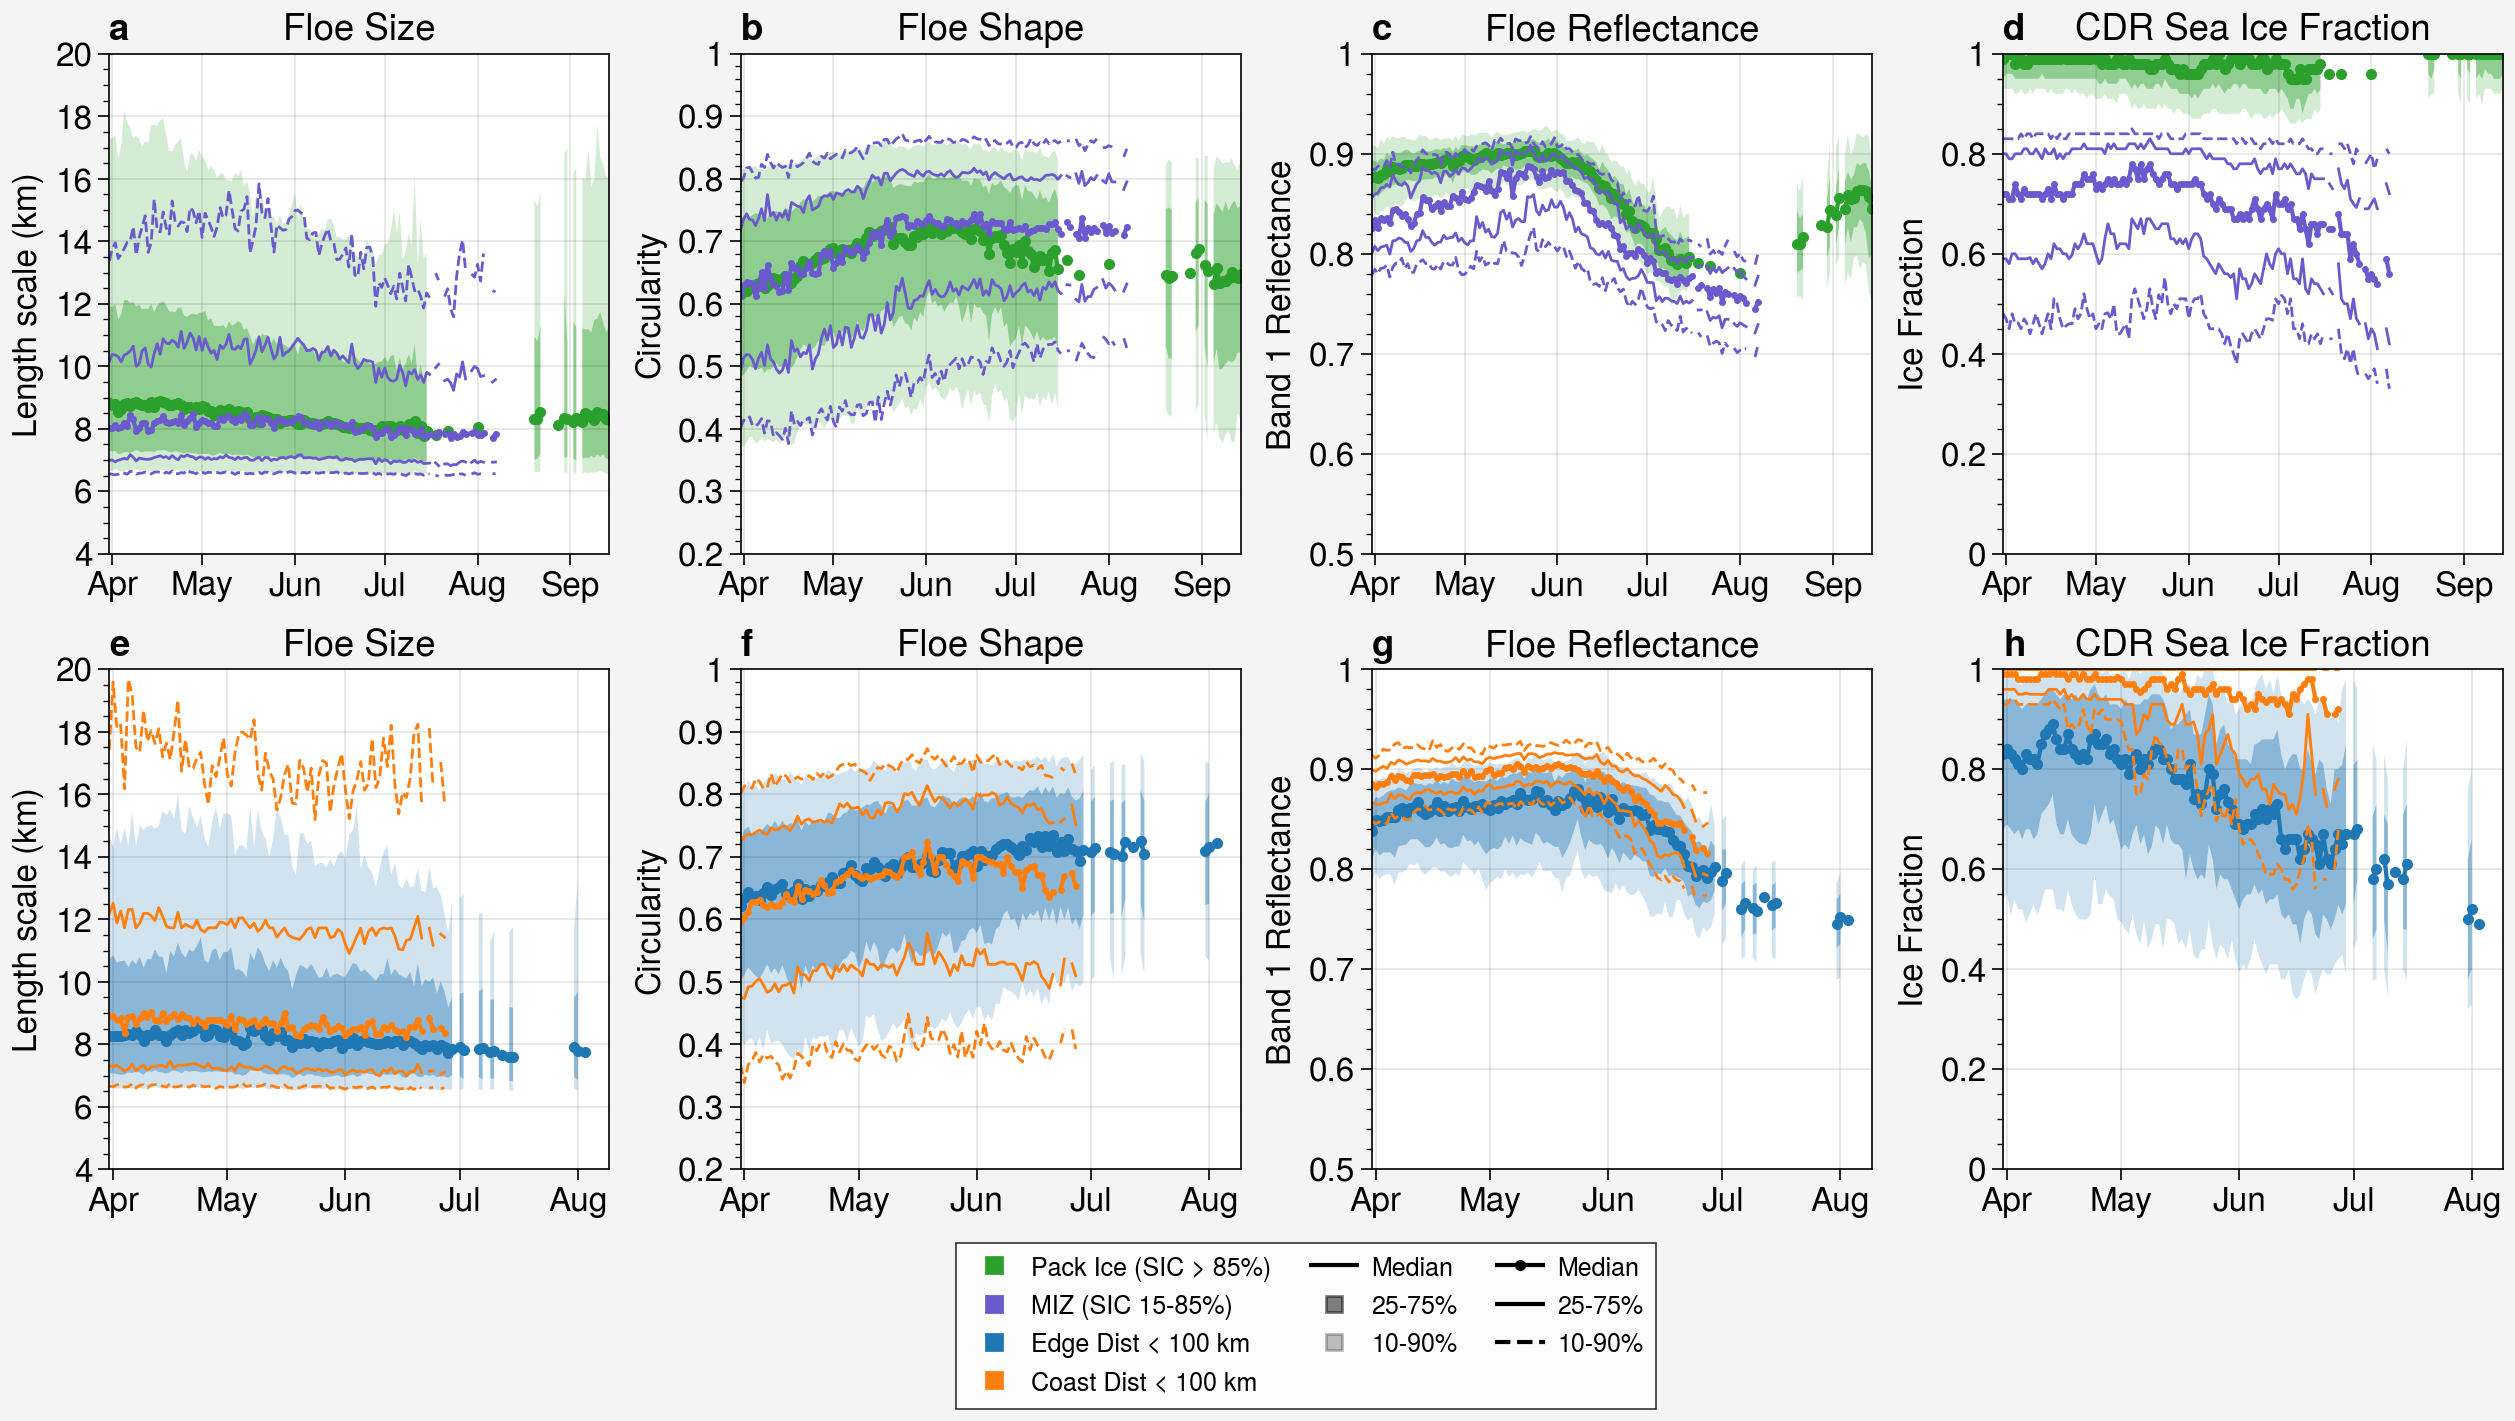

In [157]:
df['band_1_reflectance'] = df['tc_channel0']/255
df['month'] = df.datetime.dt.month
df['n'] = df.groupby('datetime').transform(lambda x: len(x))['area']
df['length_scale_km'] = df['area_adj_km']**0.5
fig, axs = pplt.subplots(ncols=4, share=False, nrows=2)

idx = df.n > 30
idx = idx & df.nsidc_sic.between(0.85, 1)
idx = idx & df.final_classification
for col, var, ylims in zip([0, 1, 2, 3],
                          ['length_scale_km', 'circularity', 'band_1_reflectance', 'nsidc_sic'],
                          [(4, 20), (0.2, 1), (0.5, 1), (0, 1)]):
    # shade data
    ax = axs[0,col]
    n = df.loc[idx, [var, 'doy']].groupby('doy').count()
    med = df.loc[idx, [var, 'doy']].groupby('doy').median().where(n > 500)
    p90 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.90).where(n > 500)
    p10 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.10).where(n > 500)
    p75 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.75).where(n > 500)
    p25 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.25).where(n > 500)
    ax.plot(med[var], fadedata=[p90[var], p10[var]],
            shadedata=[p75[var], p25[var]], marker='.', color='tab:green', label='Pack Ice')
    ax.format(ylabel=var.replace('_', ' '),
              xlocator=dr.dayofyear,
              xformatter=[d.strftime('%b') for d in dr],
              xlabel='', fontsize=12, ylim=ylims)

idx = df.n > 30
idx = idx & df.nsidc_sic.between(0.15, 0.85)
idx = idx & df.final_classification
for col, var, ylims in zip([0, 1, 2, 3],
                          ['length_scale_km', 'circularity', 'band_1_reflectance', 'nsidc_sic'],
                          [(4, 20), (0.2, 1), (0.5, 1), (0, 1)]):
    ax = axs[0,col]
    n = df.loc[idx, [var, 'doy']].groupby('doy').count()
    med = df.loc[idx, [var, 'doy']].groupby('doy').median().where(n > 500)
    p90 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.90).where(n > 500)
    p10 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.10).where(n > 500)
    p75 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.75).where(n > 500)
    p25 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.25).where(n > 500)
    
    # overlay lines
    c = 'slateblue'
    ax.plot(med[var], marker='.', color=c, ms=3, label='MIZ')
    ax.plot(p75[var], ls='-', lw=1, color=c, label='')
    ax.plot(p25[var], ls='-', lw=1, color=c, label='')
    ax.plot(p90[var], ls='--', lw=1, color=c, label='')
    ax.plot(p10[var], ls='--', lw=1, color=c, label='')
    ax.format(ylabel=var.replace('_', ' '),
              xlocator=dr.dayofyear,
              xformatter=[d.strftime('%b') for d in dr],
              xlabel='', fontsize=12, ylim=ylims)
axs[0,0].format(ylabel='Length scale (km)', title='Floe Size')
axs[0,1].format(ylabel='Circularity', title='Floe Shape')
axs[0,2].format(ylabel='Band 1 Reflectance', title='Floe Reflectance')
axs[0,3].format(ylabel='Ice Fraction', title='CDR Sea Ice Fraction')

# axs[0,2].legend(ncols=1, loc='ll')




idx = df.n > 30
idx = idx & df.edge_dist_km.between(0, 100) & (df.coast_dist_km > 100)
idx = idx & df.final_classification
for col, var, ylims in zip([0, 1, 2, 3],
                          ['length_scale_km', 'circularity', 'band_1_reflectance', 'nsidc_sic'],
                          [(4, 20), (0.2, 1), (0.5, 1), (0, 1)]):
    # shade data
    ax = axs[1, col]
    n = df.loc[idx, [var, 'doy']].groupby('doy').count()
    med = df.loc[idx, [var, 'doy']].groupby('doy').median().where(n > 500)
    p90 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.90).where(n > 500)
    p10 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.10).where(n > 500)
    p75 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.75).where(n > 500)
    p25 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.25).where(n > 500)
    ax.plot(med[var], fadedata=[p90[var], p10[var]],
            shadedata=[p75[var], p25[var]], marker='.', color='tab:blue', label='Edge')
    ax.format(ylabel=var.replace('_', ' '),
              xlocator=dr.dayofyear,
              xformatter=[d.strftime('%b') for d in dr],
              xlabel='', fontsize=12, ylim=ylims)

idx = df.n > 30
idx = idx & df.coast_dist_km.between(0, 100) & (df.edge_dist_km > 100)
idx = idx & df.final_classification
for col, var, ylims in zip([0, 1, 2, 3],
                          ['length_scale_km', 'circularity', 'band_1_reflectance', 'nsidc_sic'],
                          [(4, 20), (0.2, 1), (0.5, 1), (0, 1)]):
    ax = axs[1, col]
    n = df.loc[idx, [var, 'doy']].groupby('doy').count()
    med = df.loc[idx, [var, 'doy']].groupby('doy').median().where(n > 500)
    p90 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.90).where(n > 500)
    p10 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.10).where(n > 500)
    p75 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.75).where(n > 500)
    p25 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.25).where(n > 500)
    
    # overlay lines
    ax.plot(med[var], marker='.', color='tab:orange', ms=3, label='Coastal')
    ax.plot(p75[var], ls='-', lw=1, color='tab:orange', label='')
    ax.plot(p25[var], ls='-', lw=1, color='tab:orange', label='')
    ax.plot(p90[var], ls='--', lw=1, color='tab:orange', label='')
    ax.plot(p10[var], ls='--', lw=1, color='tab:orange', label='')
    ax.format(ylabel=var.replace('_', ' '),
              xlocator=dr.dayofyear,
              xformatter=[d.strftime('%b') for d in dr],
              xlabel='', fontsize=12, ylim=ylims)
axs[1, 0].format(ylabel='Length scale (km)', title='Floe Size')
axs[1, 1].format(ylabel='Circularity', title='Floe Shape')
axs[1, 2].format(ylabel='Band 1 Reflectance', title='Floe Reflectance')
axs[1, 3].format(ylabel='Ice Fraction', title='CDR Sea Ice Fraction')
# axs[1, 2].legend(ncols=1, loc='ll')
axs.format(abc=True)



# Legends

h = []
for c in ['tab:green', 'slateblue', 'tab:blue', 'tab:orange']:
    h.append(ax.plot([],[],color=c, marker='s',  lw=0))

for alpha, ls, m in zip([1, 0.5, 0.25], ['-', '', ''], ['', 's', 's']):
    h.append(ax.plot([],[],color='k', alpha=alpha, ls=ls, m=m))

for lw, ls, m in zip([2, 1, 1], ['-', '-', '--'], ['.', '', '']):
    h.append(ax.plot([],[],color='k', alpha=1, ls=ls, m=m))

fig.legend(h, ['Pack Ice (SIC > 85%)',
               'MIZ (SIC 15-85%)',
               'Edge Dist < 100 km',
               'Coast Dist < 100 km',
               'Median', '25-75%', '10-90%',
               'Median', '25-75%', '10-90%'], ncols=3, loc='b', order='F')


fig.save('../figures/floe_properties_seasonality.png', dpi=300)

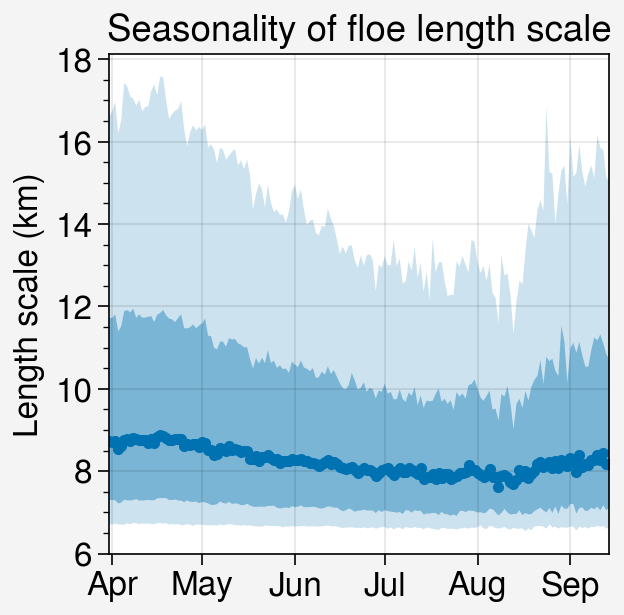

In [2]:
df['month'] = df.datetime.dt.month
df['n'] = df.groupby('datetime').transform(lambda x: len(x))['area']
df['length_scale_km'] = df['area_adj_km']**0.5
idx = df.n > 30
idx = idx & df.area_adj_km.between(41, 90e3)
idx = idx & df.lr_classification
n = df.loc[idx, ['area_adj_km', 'length_scale_km', 'doy']].groupby('doy').count()
med = df.loc[idx, ['area_adj_km', 'length_scale_km', 'doy']].groupby('doy').median()
p90 = df.loc[idx, ['area_adj_km', 'length_scale_km', 'doy']].groupby('doy').quantile(0.90)
p10 = df.loc[idx, ['area_adj_km', 'length_scale_km', 'doy']].groupby('doy').quantile(0.10)
p75 = df.loc[idx, ['area_adj_km', 'length_scale_km', 'doy']].groupby('doy').quantile(0.75)
p25 = df.loc[idx, ['area_adj_km', 'length_scale_km', 'doy']].groupby('doy').quantile(0.25)
var = 'length_scale_km'
fig, ax = pplt.subplots()
ax.plot(med[var], fadedata=[p90[var], p10[var]],
        shadedata=[p75[var], p25[var]], marker='.')
ax.format(ylabel='Length scale (km)', xlocator=dr.dayofyear, xformatter=[d.strftime('%b') for d in dr],
          xlabel='', title='Seasonality of floe length scale', fontsize=12)

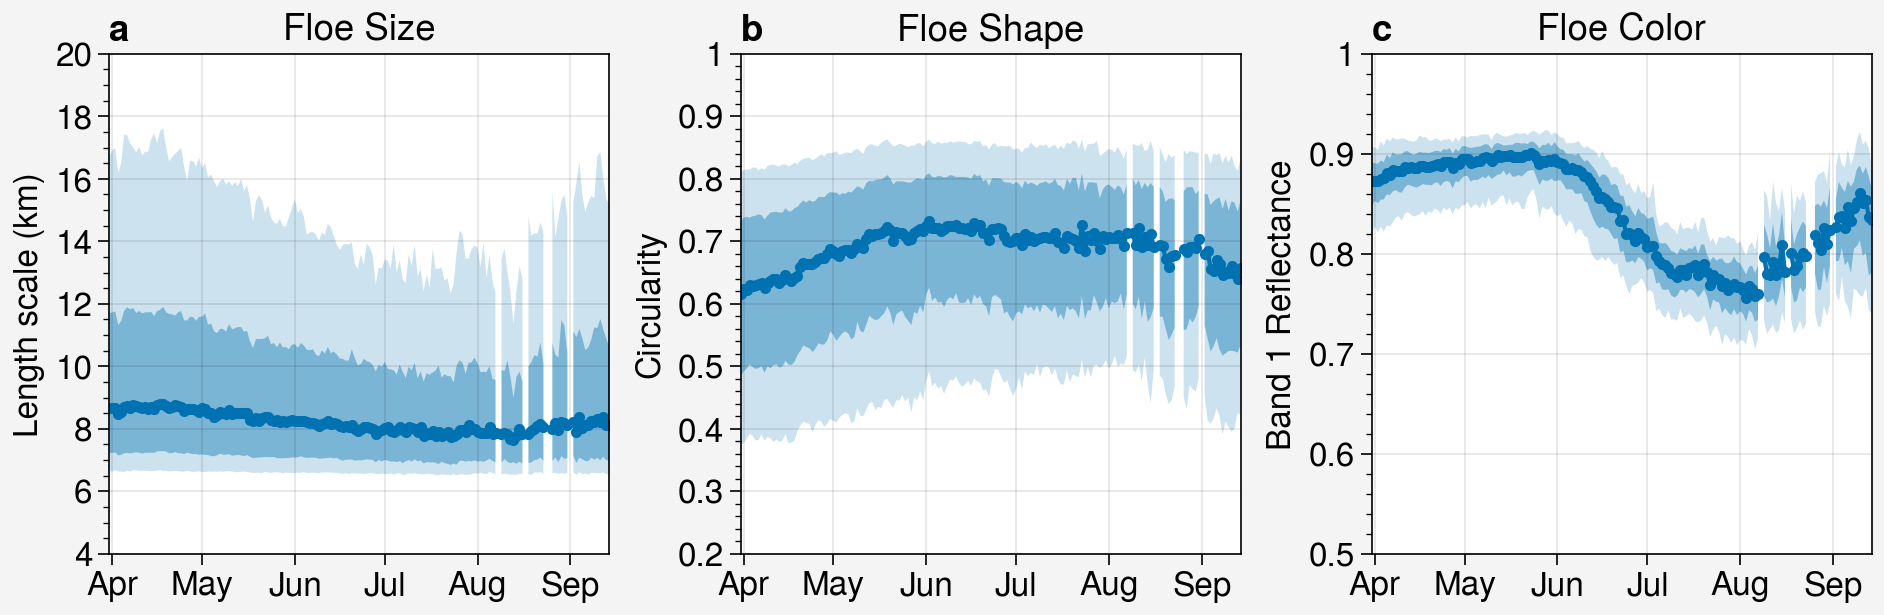

In [47]:
df['band_1_reflectance'] = df['tc_channel0']/255
df['month'] = df.datetime.dt.month
df['n'] = df.groupby('datetime').transform(lambda x: len(x))['area']
df['length_scale_km'] = df['area_adj_km']**0.5
idx = df.n > 30
# idx = idx & df.area_adj_km.between(10**2, 30**2)
idx = idx & df.final_classification
fig, axs = pplt.subplots(ncols=3, share=False)
for ax, var, ylims in zip(axs,
                          ['length_scale_km', 'circularity', 'band_1_reflectance'],
                          [(4, 20), (0.2, 1), (0.5, 1)]):

    n = df.loc[idx, [var, 'doy']].groupby('doy').count()
    med = df.loc[idx, [var, 'doy']].groupby('doy').median().where(n > 500)
    p90 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.90).where(n > 500)
    p10 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.10).where(n > 500)
    p75 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.75).where(n > 500)
    p25 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.25).where(n > 500)
    
    
    ax.plot(med[var], fadedata=[p90[var], p10[var]],
            shadedata=[p75[var], p25[var]], marker='.')
    ax.format(ylabel=var.replace('_', ' '),
              xlocator=dr.dayofyear,
              xformatter=[d.strftime('%b') for d in dr],
              xlabel='', fontsize=12, ylim=ylims)
axs[0].format(ylabel='Length scale (km)', title='Floe Size')
axs[1].format(ylabel='Circularity', title='Floe Shape')
axs[2].format(ylabel='Band 1 Reflectance', title='Floe Color')
axs.format(abc=True)

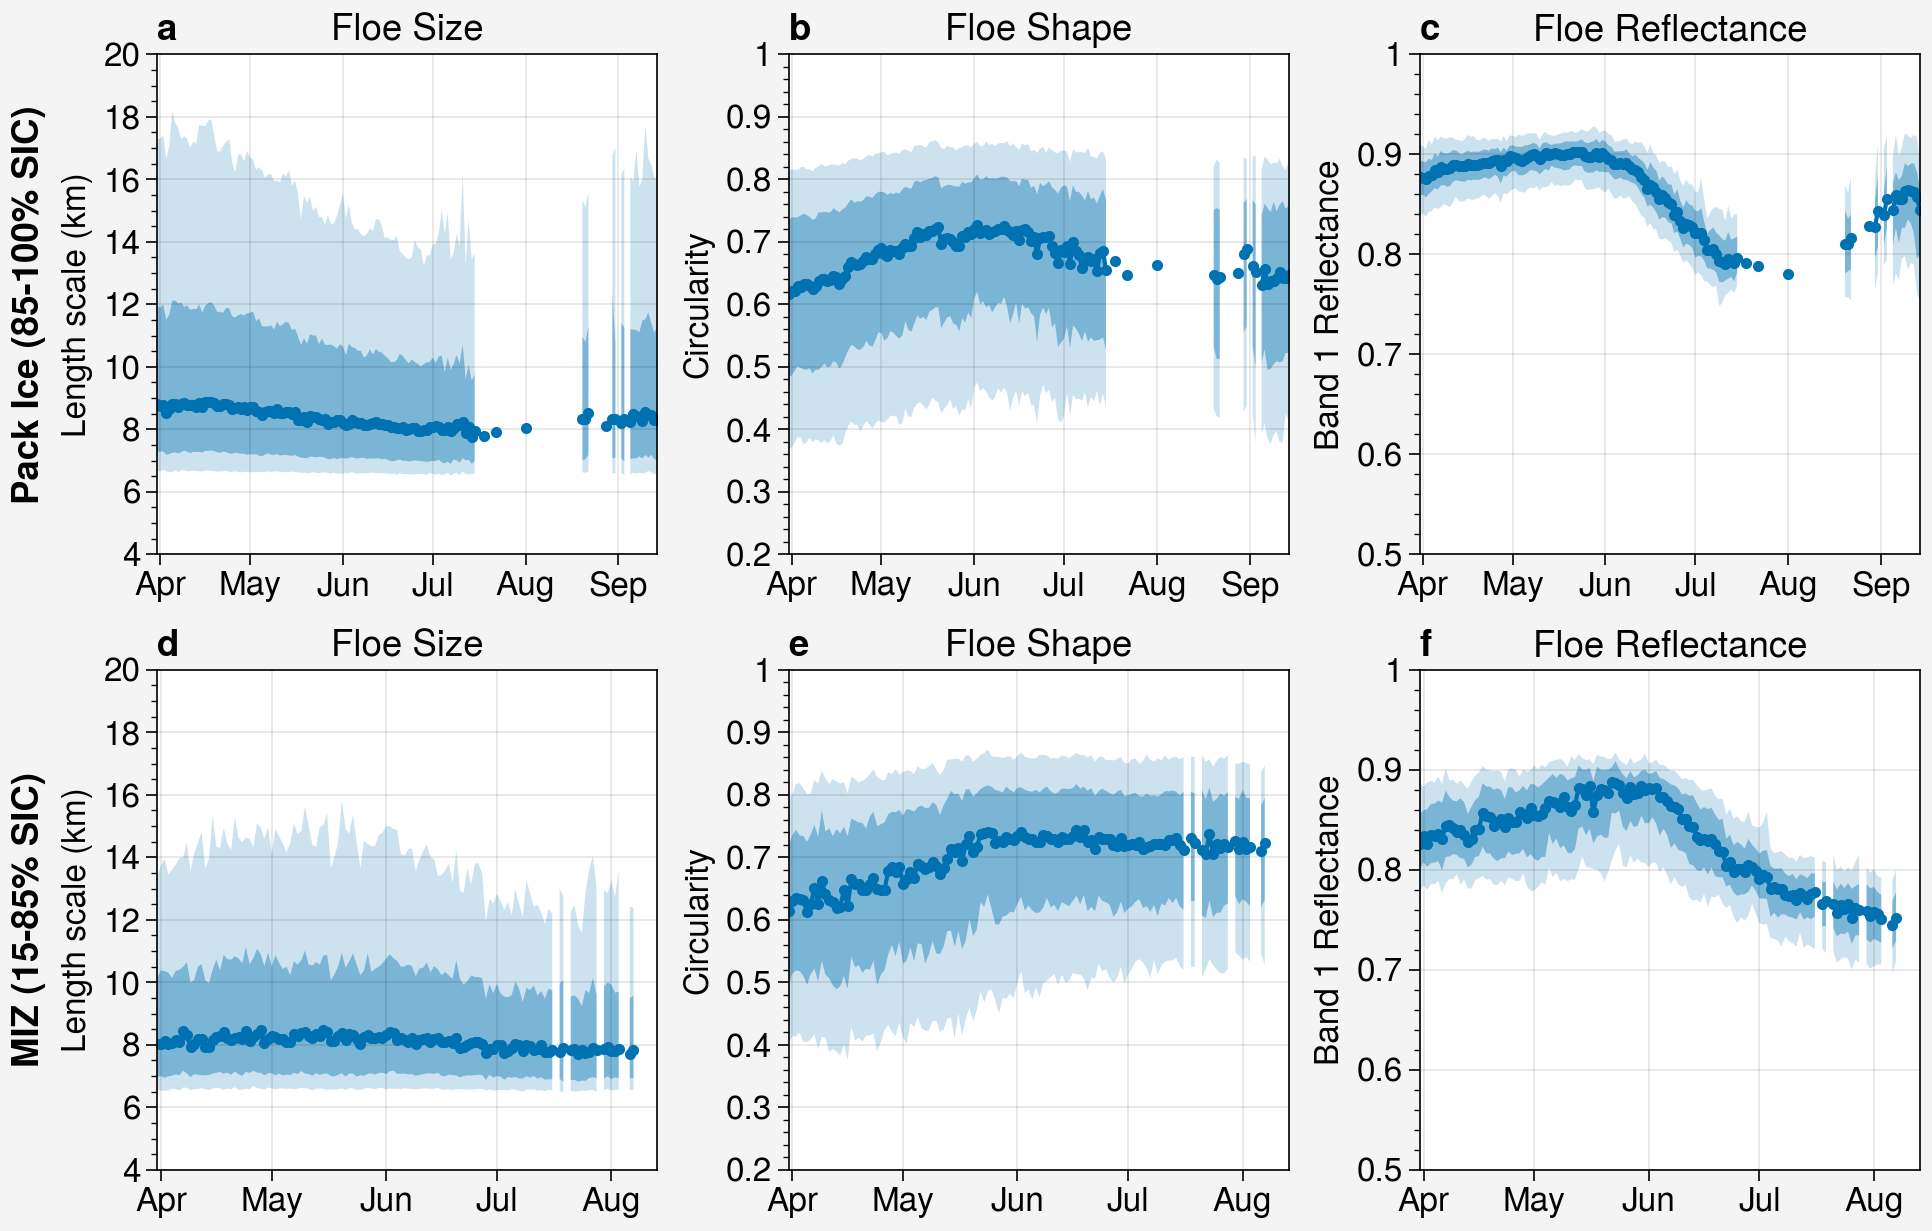

In [205]:
df['band_1_reflectance'] = df['tc_channel0']/255
df['month'] = df.datetime.dt.month
df['n'] = df.groupby('datetime').transform(lambda x: len(x))['area']
df['length_scale_km'] = df['area_adj_km']**0.5
fig, axs = pplt.subplots(ncols=3, share=False, nrows=2)
idx = df.n > 30
idx = idx & df.nsidc_sic.between(0.85, 1)
idx = idx & df.final_classification
for ax, var, ylims in zip(axs[0,:],
                          ['length_scale_km', 'circularity', 'band_1_reflectance'],
                          [(4, 20), (0.2, 1), (0.5, 1)]):

    n = df.loc[idx, [var, 'doy']].groupby('doy').count()
    med = df.loc[idx, [var, 'doy']].groupby('doy').median().where(n > 500)
    p90 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.90).where(n > 500)
    p10 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.10).where(n > 500)
    p75 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.75).where(n > 500)
    p25 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.25).where(n > 500)
    
    
    ax.plot(med[var], fadedata=[p90[var], p10[var]],
            shadedata=[p75[var], p25[var]], marker='.')
    ax.format(ylabel=var.replace('_', ' '),
              xlocator=dr.dayofyear,
              xformatter=[d.strftime('%b') for d in dr],
              xlabel='', fontsize=12, ylim=ylims)
axs[0, 0].format(ylabel='Length scale (km)', title='Floe Size')
axs[0, 1].format(ylabel='Circularity', title='Floe Shape')
axs[0, 2].format(ylabel='Band 1 Reflectance', title='Floe Reflectance')

idx = df.n > 30
idx = idx & df.nsidc_sic.between(0.15, 0.85)
idx = idx & df.final_classification
for ax, var, ylims in zip(axs[1,:],
                          ['length_scale_km', 'circularity', 'band_1_reflectance'],
                          [(4, 20), (0.2, 1), (0.5, 1)]):

    n = df.loc[idx, [var, 'doy']].groupby('doy').count()
    med = df.loc[idx, [var, 'doy']].groupby('doy').median().where(n > 500)
    p90 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.90).where(n > 500)
    p10 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.10).where(n > 500)
    p75 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.75).where(n > 500)
    p25 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.25).where(n > 500)
    
    
    ax.plot(med[var], fadedata=[p90[var], p10[var]],
            shadedata=[p75[var], p25[var]], marker='.')
    ax.format(ylabel=var.replace('_', ' '),
              xlocator=dr.dayofyear,
              xformatter=[d.strftime('%b') for d in dr],
              xlabel='', fontsize=12, ylim=ylims)
axs[1, 0].format(ylabel='Length scale (km)', title='Floe Size')
axs[1, 1].format(ylabel='Circularity', title='Floe Shape')
axs[1, 2].format(ylabel='Band 1 Reflectance', title='Floe Reflectance')

axs.format(abc=True, leftlabels=['Pack Ice (85-100% SIC)', 'MIZ (15-85% SIC)'])
fig.save('../figures/figXX_seasonality_floe_properties.pdf', dpi=300)

In [104]:
nsidc_sie = pd.read_csv('../data/cdr_sea_ice_extent.csv', index_col=0, parse_dates = True)
asi_sie = pd.read_csv('../data/asi_sea_ice_extent.csv', index_col=0, parse_dates = True)
asi_sie = asi_sie.where(asi_sie['sea_ice_extent'] > 1)

/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_70311/3502915563.py:17: RuntimeWarning: invalid value encountered in divide
  group['miz_ice_extent'].values/group['sea_ice_extent'].values * 100,


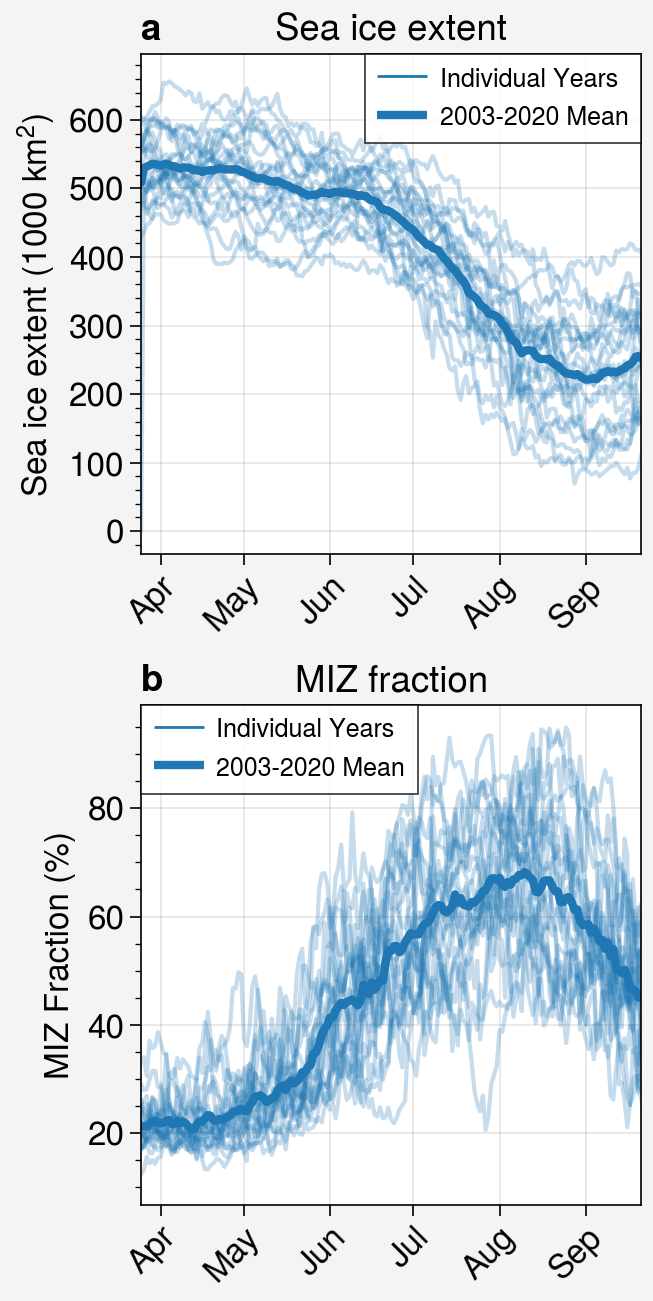

In [209]:
## Sea ice extent 
fig, axs = uplt.subplots(nrows=2, share=False)
ax = axs[0]
for year, group in nsidc_sie.groupby(nsidc_sie.index.year):
    ax.plot(group.index.dayofyear,
            group['sea_ice_extent'].values/1e9, alpha=0.25, color='tab:blue')
mean_extent = nsidc_sie.groupby(nsidc_sie.index.dayofyear).mean()
ax.plot(mean_extent.index,
            mean_extent['sea_ice_extent'].values/1e9, alpha=1, lw=3, color='tab:blue')
ax.format(ylabel='Sea ice extent (1000 km$^2$)',  xlocator=dr.dayofyear, xformatter=[d.strftime('%b') for d in dr],
          xlabel='', xrotation=45, fontsize=12, xlim=(85, 265), title='Sea ice extent')

## MIZ fraction
ax = axs[1]
for year, group in nsidc_sie.groupby(nsidc_sie.index.year):
    ax.plot(group.index.dayofyear,
            group['miz_ice_extent'].values/group['sea_ice_extent'].values * 100,
           alpha=0.25, color='tab:blue')
nsidc_sie['miz_percent'] = nsidc_sie['miz_ice_extent'] / nsidc_sie['sea_ice_extent']

mean_percent = nsidc_sie.groupby(nsidc_sie.index.dayofyear).mean()
ax.plot(mean_percent.index,
            mean_percent['miz_percent'].values*100, alpha=1, lw=3, color='tab:blue')
ax.format(ylabel='MIZ Fraction (%)', xlocator=dr.dayofyear, xformatter=[d.strftime('%b') for d in dr],
          xlabel='', xrotation=45, fontsize=12, xlim=(85, 265), title='MIZ fraction')

h = []
for alpha, ls, m in zip([1, 0.5, 0.25], ['-', '', ''], ['', 's', 's']):
    h.append(ax.plot([],[],color='tab:blue', alpha=alpha, ls=ls, m=m))
h = [ax.plot([], [], color='tab:blue', lw=1, alpha=1),
     ax.plot([], [], color='tab:blue', lw=3, alpha=1)]
axs[0].legend(h, ['Individual Years', '2003-2020 Mean'], ncols=1,  loc='ur')
axs[1].legend(h, ['Individual Years', '2003-2020 Mean'], ncols=1, loc='ul')

axs.format(abc=True)
fig.save('../figures/figXX_cdr_sea_ice_extent.pdf', dpi=300)

In [ ]:
## Sea ice extent 
fig, axs = uplt.subplots(nrows=2, ncols=2, share=False)
ax = axs[0,0]
for year, group in nsidc_sie.groupby(nsidc_sie.index.year):
    ax.plot(group.index.dayofyear,
            group['sea_ice_extent'].values/1e9, alpha=0.25, color='tab:blue')
mean_extent = nsidc_sie.groupby(nsidc_sie.index.dayofyear).mean()
ax.plot(mean_extent.index,
            mean_extent['sea_ice_extent'].values/1e9, alpha=1, lw=3, color='tab:blue')
ax.format(ylabel='Sea ice extent (1000 km$^2$)',  xlocator=dr.dayofyear, xformatter=[d.strftime('%b') for d in dr],
          xlabel='', xrotation=45, fontsize=12, xlim=(85, 265), title='Sea ice extent')

ax = axs[0,1]
for year, group in asi_sie.groupby(asi_sie.index.year):
    ax.plot(group.index.dayofyear,
            group['sea_ice_extent'].values/1e9, alpha=0.25, color='tab:red')
mean_extent = asi_sie.groupby(asi_sie.index.dayofyear).mean()
ax.plot(mean_extent.index,
            mean_extent['sea_ice_extent'].values/1e9, alpha=1, lw=3, color='tab:red')
ax.format(ylabel='Sea ice extent (1000 km$^2$)',  xlocator=dr.dayofyear, xformatter=[d.strftime('%b') for d in dr],
          xlabel='', xrotation=45, fontsize=12, xlim=(85, 265), title='Sea ice extent')


## MIZ fraction
ax = axs[1, 0]
for year, group in nsidc_sie.groupby(nsidc_sie.index.year):
    ax.plot(group.index.dayofyear,
            group['miz_ice_extent'].values/group['sea_ice_extent'].values * 100,
           alpha=0.25, color='tab:blue')
nsidc_sie['miz_percent'] = nsidc_sie['miz_ice_extent'] / nsidc_sie['sea_ice_extent']

mean_percent = nsidc_sie.groupby(nsidc_sie.index.dayofyear).mean()
ax.plot(mean_percent.index,
            mean_percent['miz_percent'].values*100, alpha=1, lw=3, color='tab:blue')
ax.format(ylabel='MIZ Fraction (%)', xlocator=dr.dayofyear, xformatter=[d.strftime('%b') for d in dr],
          xlabel='', xrotation=45, fontsize=12, xlim=(85, 265), title='MIZ fraction')
ax = axs[1, 1]
for year, group in asi_sie.groupby(asi_sie.index.year):
    ax.plot(group.index.dayofyear,
            group['miz_ice_extent'].values/group['sea_ice_extent'].values * 100,
           alpha=0.25, color='tab:red')
asi_sie['miz_percent'] = asi_sie['miz_ice_extent'] / asi_sie['sea_ice_extent']

mean_percent = asi_sie.groupby(asi_sie.index.dayofyear).mean()
ax.plot(mean_percent.index,
            mean_percent['miz_percent'].values*100, alpha=1, lw=3, color='tab:red')
ax.format(ylabel='MIZ Fraction (%)', xlocator=dr.dayofyear, xformatter=[d.strftime('%b') for d in dr],
          xlabel='', xrotation=45, fontsize=12, xlim=(85, 265), title='MIZ fraction')



h = []
for alpha, ls, m in zip([1, 0.5, 0.25], ['-', '', ''], ['', 's', 's']):
    h.append(ax.plot([],[],color='tab:blue', alpha=alpha, ls=ls, m=m))
h = [ax.plot([], [], color='tab:blue', lw=1, alpha=1),
     ax.plot([], [], color='tab:blue', lw=3, alpha=1)]
axs[0].legend(h, ['Individual Years', '2003-2020 Mean'], ncols=1,  loc='ur')
axs[1].legend(h, ['Individual Years', '2003-2020 Mean'], ncols=1, loc='ur')

axs.format(abc=True, toplabels=['NSIDC CDR', 'ASI'])

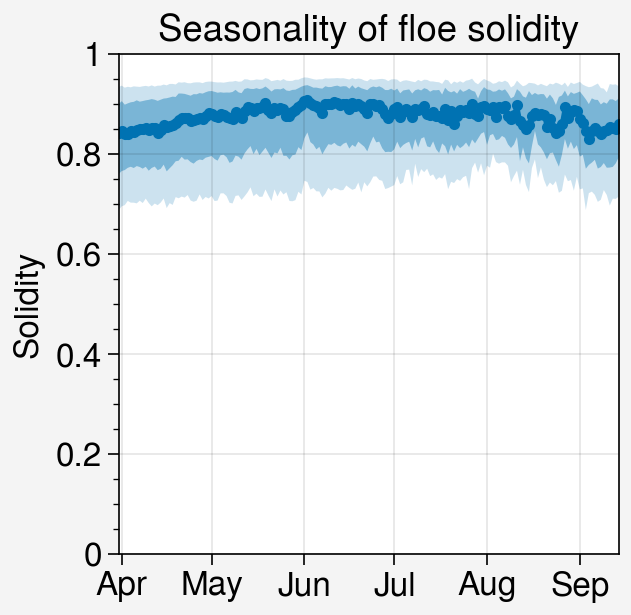

In [56]:
df['month'] = df.datetime.dt.month
df['n'] = df.groupby('datetime').transform(lambda x: len(x))['area']
df['length_scale_km'] = df['area_adj_km']**0.5
idx = df.n > 30
idx = idx & df.area_adj_km.between(10**2, 30**2)
idx = idx & df.final_classification
var = 'solidity'
n = df.loc[idx, [var, 'doy']].groupby('doy').count()
med = df.loc[idx, [var, 'doy']].groupby('doy').median()
p90 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.90)
p10 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.10)
p75 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.75)
p25 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.25)

fig, ax = pplt.subplots()
ax.plot(med[var], fadedata=[p90[var], p10[var]],
        shadedata=[p75[var], p25[var]], marker='.')
ax.format(ylabel='Solidity', xlocator=dr.dayofyear, xformatter=[d.strftime('%b') for d in dr],
          xlabel='', title='Seasonality of floe solidity', fontsize=12, ylim=(0, 1))

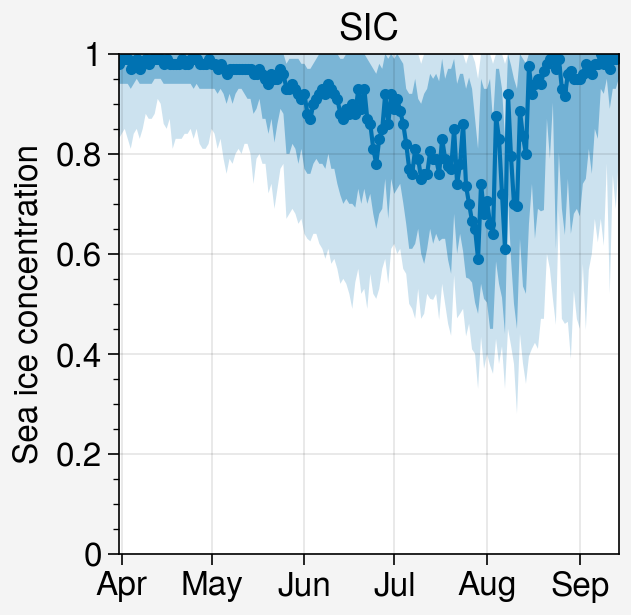

In [14]:
df['month'] = df.datetime.dt.month
df['n'] = df.groupby('datetime').transform(lambda x: len(x))['area']
df['length_scale_km'] = df['area_adj_km']**0.5
idx = df.n > 30
idx = idx & df.area_adj_km.between(10**2, 30**2)
idx = idx & df.final_classification
var = 'nsidc_sic'
n = df.loc[idx, [var, 'doy']].groupby('doy').count()
med = df.loc[idx, [var, 'doy']].groupby('doy').median()
p90 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.90)
p10 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.10)
p75 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.75)
p25 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.25)

fig, ax = pplt.subplots()
ax.plot(med[var], fadedata=[p90[var], p10[var]],
        shadedata=[p75[var], p25[var]], marker='.')
ax.format(ylabel='Sea ice concentration', xlocator=dr.dayofyear, xformatter=[d.strftime('%b') for d in dr],
          xlabel='', title='SIC', fontsize=12, ylim=(0, 1))

# Floe color
Floes get darker as ice melts and melt ponds form. 

<a list of 1 Line2D objects>

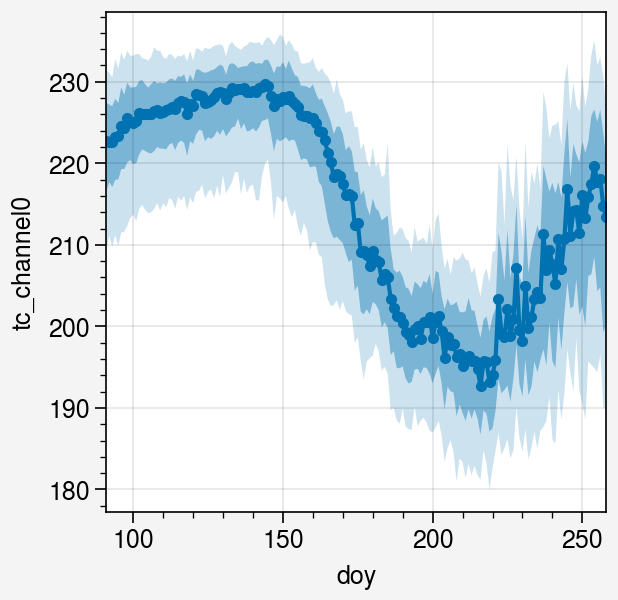

In [103]:
idx = df.n > 30
idx = idx & df.area_adj_km.between(41, 90e3)
idx = idx & df.lr_classification
n = df.loc[idx, ['tc_channel0', 'tc_channel0', 'doy']].groupby('doy').count()
med = df.loc[idx, ['tc_channel0', 'fc_channel0', 'doy']].groupby('doy').median()
p90 = df.loc[idx, ['tc_channel0', 'fc_channel0', 'doy']].groupby('doy').quantile(0.90)
p10 = df.loc[idx, ['tc_channel0', 'fc_channel0', 'doy']].groupby('doy').quantile(0.10)
p75 = df.loc[idx, ['tc_channel0', 'fc_channel0', 'doy']].groupby('doy').quantile(0.75)
p25 = df.loc[idx, ['tc_channel0', 'fc_channel0', 'doy']].groupby('doy').quantile(0.25)
var = 'tc_channel0'
fig, ax = pplt.subplots()
ax.plot(med[var], fadedata=[p90[var], p10[var]],
        shadedata=[p75[var], p25[var]], marker='.')


There's a prettty clear seasonality in the color of the detected floes that I think will be worth looking into at some point. The detected floes are brightest in april/may, then near the minimum and the transition times, we have much darker ice. Still bright, mind you!

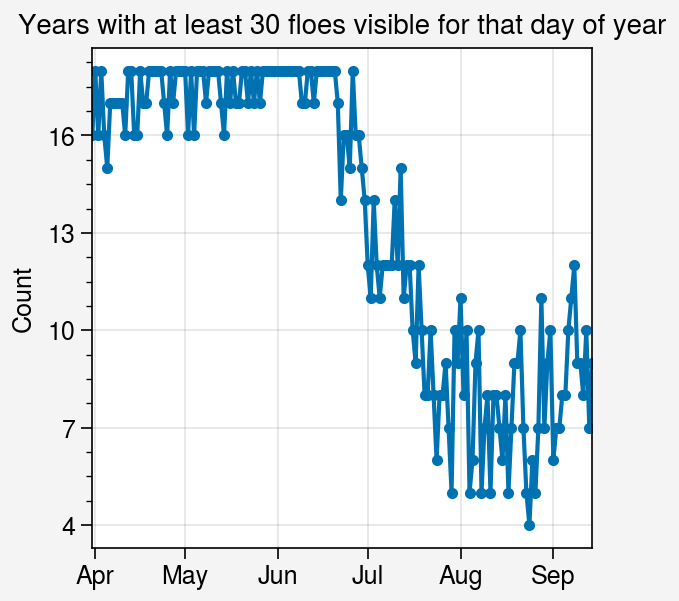

In [99]:
fig, ax = pplt.subplots()
counts = df.loc[idx, :].groupby(['year', 'doy']).count().pivot_table(index='year', columns='doy', values='area').T.notnull()
ax.plot(counts.sum(axis=1), marker='.')
ax.format(yticks=np.arange(1, 18, 3), 
         xlocator=dr.dayofyear, title='Years with at least 30 floes visible for that day of year',
          ylabel='Count',
          xformatter=[d.strftime('%b') for d in dr],
          xlabel='')

### Summary statistics (FSD alpha)

In [124]:
df_pivot[month_idx].quantile(0.5)

month
4    1.978623
5    2.113421
6    2.295665
Name: 0.5, dtype: float64

In [125]:
df_pivot[month_idx].quantile(0.75) - df_pivot[month_idx].quantile(0.25)

month
4    0.262171
5    0.277895
6    0.249395
dtype: float64

In [126]:
df_pivot[month_idx].quantile(0.9) - df_pivot[month_idx].quantile(0.1)

month
4    0.480360
5    0.560865
6    0.522160
dtype: float64

### Comparison of seasonality with standard power law
Although we find that the likelihood of the standard power law is lower than that of the truncated power law, it is useful to see how sensitive our results are to that choice. We find that the sample-to-sample spread is larger with the truncated power law, potential due to the more flexible fitting with two parameters, and that the same timing appears in both (minimum in april, maximum in july/aug, however the minimum is lower for the truncated power law.

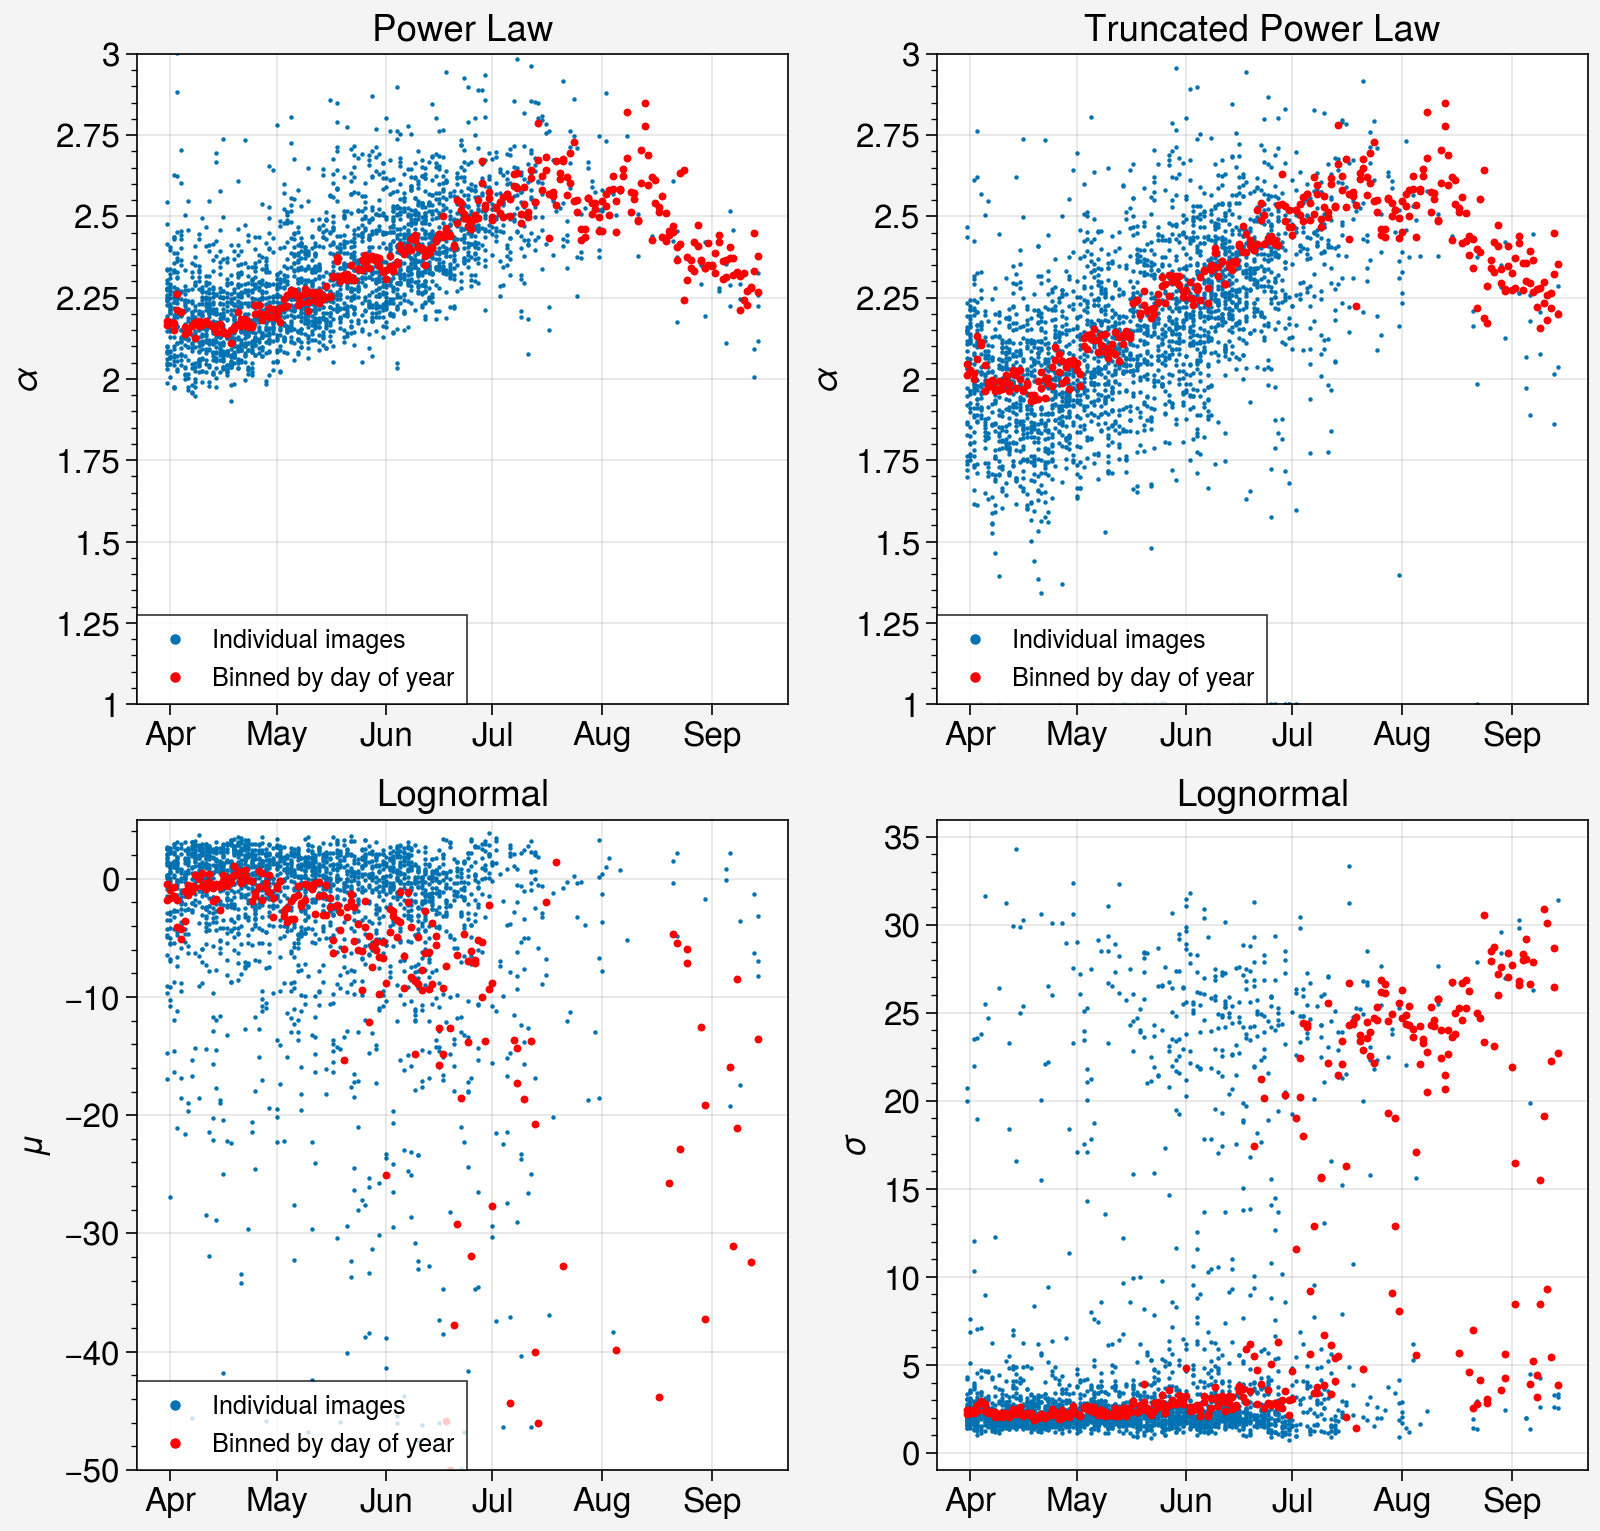

In [225]:
fig, axs = pplt.subplots(width=8, ncols=2,nrows=2, share=False)
min_n = 100
time_idx = (results.month != 3) & (results.month <= 9)
for ax, var, title in zip(axs[0,:], ['alpha', 'alpha_tpl'], ['Power Law', 'Truncated Power Law']):
    df_pivot = results.loc[time_idx & (results.n > min_n)].pivot_table(index='date', values=var, columns='month')
    month_counts = df_pivot.notnull().sum() 
    month_idx = [m for m in month_counts.index if month_counts[m] > 100]
    _ = ax.scatter(results.loc[results.n > min_n].date.dt.dayofyear/30, results.loc[results.n > min_n, var], marker='o', ms=1, zorder=0, label='Individual images')
    _ = ax.scatter(results_alt.doy/30, results_alt[var], marker='o', ms=5, zorder=0, color='r', label='Binned by day of year')
    
    ax.format(xlocator=dr.dayofyear/30, xformatter=[d.strftime('%b') for d in dr],
              xlabel='', fontsize=12, title=title)
axs[0,0].format(ylabel='$\\alpha$', ylim=(1, 3))
axs[0,1].format(ylabel='$\\alpha$', ylim=(1, 3))
axs[0,0].legend(loc='ll', ncols=1, ms=10)
axs[0,1].legend(loc='ll', ncols=1, ms=10)

min_n = 100
time_idx = (results.month != 3) & (results.month <= 9)
for ax, var, title in zip(axs[1,:], ['mu', 'sigma'], ['Lognormal', 'Lognormal']):
    df_pivot = results.loc[time_idx & (results.n > min_n)].pivot_table(index='date', values=var, columns='month')
    month_counts = df_pivot.notnull().sum() 
    month_idx = [m for m in month_counts.index if month_counts[m] > 100]
    _ = ax.scatter(results.loc[results.n > min_n].date.dt.dayofyear/30, results.loc[results.n > min_n, var], marker='o', ms=1, zorder=0, label='Individual images')
    _ = ax.scatter(results_alt.doy/30, results_alt[var], marker='o', ms=5, zorder=0, color='r', label='Binned by day of year')
    
    ax.format(xlocator=dr.dayofyear/30, xformatter=[d.strftime('%b') for d in dr],
              xlabel='', fontsize=12, title=title)
axs[1,0].format(ylabel='$\\mu$', ylim=(-50, 5))
axs[1,1].format(ylabel='$\\sigma$')
axs[1,0].legend(loc='ll', ncols=1, ms=10)


fig.save('../figures/fsd_fitted_parameter_seasonality.png', dpi=300)

### Seasonality of the lognormal distribution fit
From this figure, we can see that there is a shift in July. It looks like there are two regions where the fit tends to hover - mu near zero and sigma between 1 and 5, or mu near -1000 and sigma between 25 and 30. By eye, it appears that the fit becomes much more erratic after July. I suspect that further analysis could determine whether this indicates a shift in the physical causes of FSD variation.

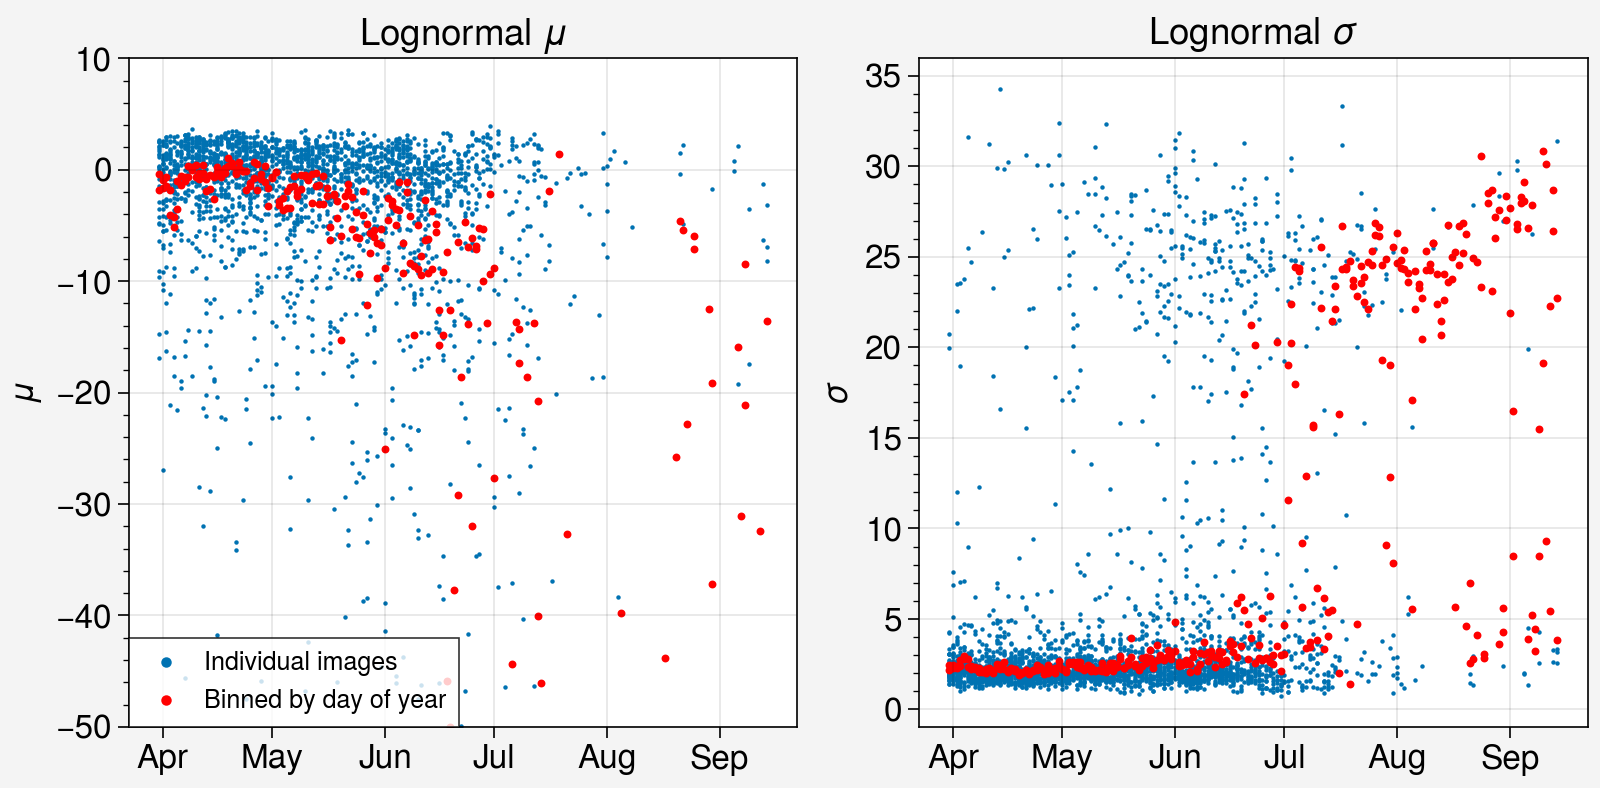

In [217]:

fig, axs = pplt.subplots(width=8, ncols=2, share=False, span=False)
min_n = 100
time_idx = (results.month != 3) & (results.month <= 9)
for ax, var, title in zip(axs, ['mu', 'sigma'], ['Lognormal $\\mu$', 'Lognormal $\\sigma$']):
    df_pivot = results.loc[time_idx & (results.n > min_n)].pivot_table(index='date', values=var, columns='month')
    month_counts = df_pivot.notnull().sum() 
    month_idx = [m for m in month_counts.index if month_counts[m] > 100]
    _ = ax.scatter(results.loc[results.n > min_n].date.dt.dayofyear/30, results.loc[results.n > min_n, var], marker='o', ms=1, zorder=0, label='Individual images')
    _ = ax.scatter(results_alt.doy/30, results_alt[var], marker='o', ms=5, zorder=0, color='r', label='Binned by day of year')
    
    ax.format(xlocator=dr.dayofyear/30, xformatter=[d.strftime('%b') for d in dr],
              xlabel='', fontsize=12, title=title)
axs[0].format(ylabel='$\\mu$', ylim=(-50, 10))
axs[1].format(ylabel='$\\sigma$')
axs[0].legend(loc='ll', ncols=1, ms=10)
fig.save('../figures/fsd_lognormal_fit_parameters.png', dpi=300)

## Tracked floes vs all floes
Checking whether the PDF and CCDF of the data are substantially different when we look at tracked floes only versus when we look at the full dataset.

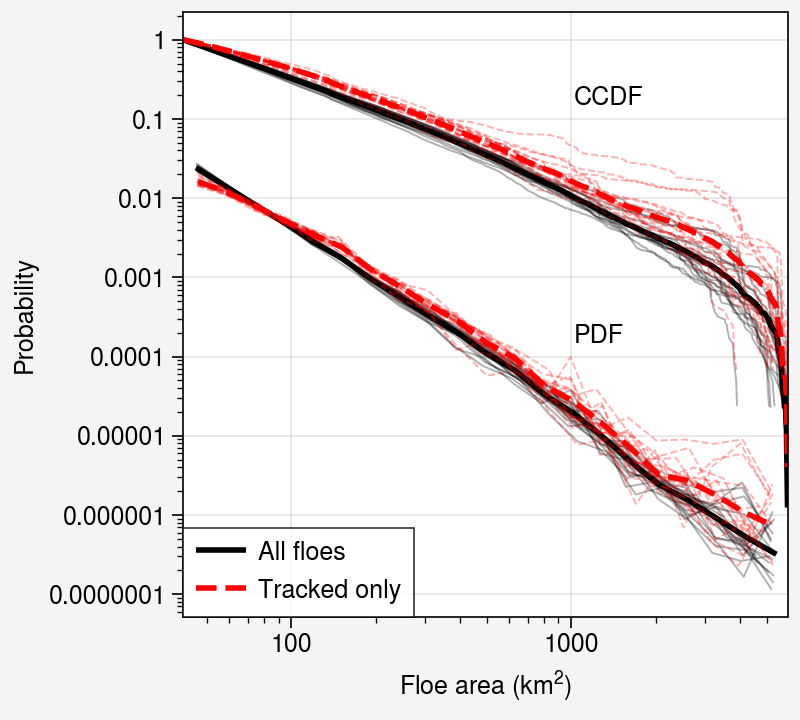

In [127]:
%run ../scripts/plot_fig_11_fsd_all_tracked_comp.py

# notes
Updated FSD analysis
* Describe new data processing method in paper
* Describe area adjustment
* Power law vs lognormal

Discussion
Stern et al. reconciliation paper
- we don't have the issue of the largest floes being excluded by image size, however we also don't know how well the data samples the existing floes -- that will have to be its own paper
- 
Displacing and interpreting the results of the lognormal vs power law values

Rothrock and Thorndike 1984 introduced error estimation when sampling the FSD
We should point out that wave fraction has been shown to lead to a lognormal distribution, and that there is likely a shift in distributions that coincides with a shift between a fracture-based distribution change and a melt-rate based distribution change.

## Caveats
- Our method is repeated samples of floe sizes, across many images, rather than exhaustive calculation in a small set of images. Cautious comparison with prior studies. Future work to examine sampling. Assuming that sampling is similar across our dataset, then we can say that there is clear steepening through spring, and a likely shift in summer towards more shallow slopes. Our data shows that 

# Comparison to prior work
- Lu et al. 2008, slope of cumulative FSD steepens as ice edge is approached (summer)
- Paget et al. 2001 - slopes steepen towards edge (winter)
- Stern et al. 2018: slope of FSD steepens in spring as large floes break up
- Perovich and Jones - lateral melting would make the slope shallower at smaller floe sizes
- Stern et al. 2018b - some studies show shallower slopes for small floes, some steeper for small floes

Rejecting null hypothesis with K-S test of fitted distribution. D converges to 0 as n increases, so a large value of D is more likely to result in rejecting the null hypothesis with a large sample. I could make a plot with the data colored by whether the distribution is significantly different than the assumed distribution.

* Potential to build on Stern et al. 2018 work -- could we use their floe segmentation of MODIS imagery as a comparison point?


* Threshold for including image - 100 floes? or higher number?
Could do a simple bootstrap approach. For each increment of 10, resample alpha. Compute the percent error.

# Revisiting Ellen's work
One big question: how different is the FSD and the mean floe size in the MIZ compared to the pack ice? The NSIDC data was not high enough resolution to really consider this, except perhaps through the distance to the ice edge criterion.

## Incorporating ASI data
- Sea ice concentration from ASI is potentially more informative due to the higher resolution


## Questions
* Better to use MIZ = 15-85% or MIZ = dist < 100 km?

In [1]:
#Import everything
import pandas as pd
import numpy as np
import ultraplot as uplt
import powerlaw
import os

In [113]:
dfs_nsidc = []
dfs_asi = []
for year in range(2003, 2021):
    dfs_nsidc.append(pd.read_csv('../data/floe_tracker/ift_floe_property_tables/with_nsidc/ift_floe_properties_{y}.csv'.format(y=year), parse_dates=['datetime']))
    dfs_asi.append(pd.read_csv('../data/floe_tracker/ift_floe_property_tables_asi/ift_raw_floe_properties_asi_{y}.csv'.format(y=year), parse_dates=['date']))

In [114]:
df_nsidc = pd.concat(dfs_nsidc)
df_asi = pd.concat(dfs_asi)

df_nsidc['date'] = pd.to_datetime({'year': df_nsidc.datetime.dt.year,
                                  'month': df_nsidc.datetime.dt.month,
                                  'day': df_nsidc.datetime.dt.day})

In [115]:
df_nsidc.shape, df_asi.shape

((773318, 42), (1844559, 26))

In [116]:
df = df_nsidc.merge(
    df_asi[['label', 'date', 'satellite', 'asi_sic_mean', 'asi_sic_std', 'area_expanded', 'perimeter_expanded', 'asi_sic_mean_coarsened']],
    left_on=['label', 'date', 'satellite'],
    right_on=['label', 'date', 'satellite'])

<a list of 1 Line2D objects>

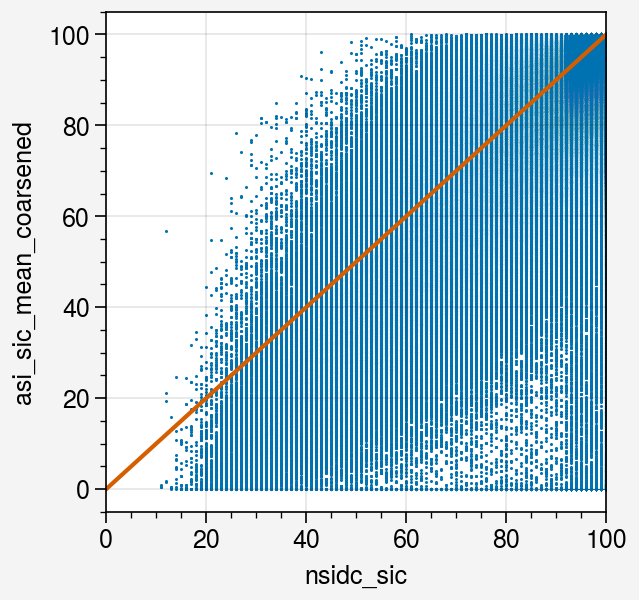

In [117]:
import ultraplot as uplt
fig, ax = uplt.subplots()
ax.scatter(df.nsidc_sic*100, df.asi_sic_mean_coarsened, ms=1, m='.')
ax.plot([0, 100], [0, 100])

In [118]:
all_areas = df.loc[df.final_classification].groupby('datetime').count()['label']
near_edge_areas = df.loc[df.final_classification & (df.edge_dist_km <= 100)].groupby('datetime').count()['label']
far_edge_areas = df.loc[df.final_classification & (df.edge_dist_km >= 300)].groupby('datetime').count()['label']

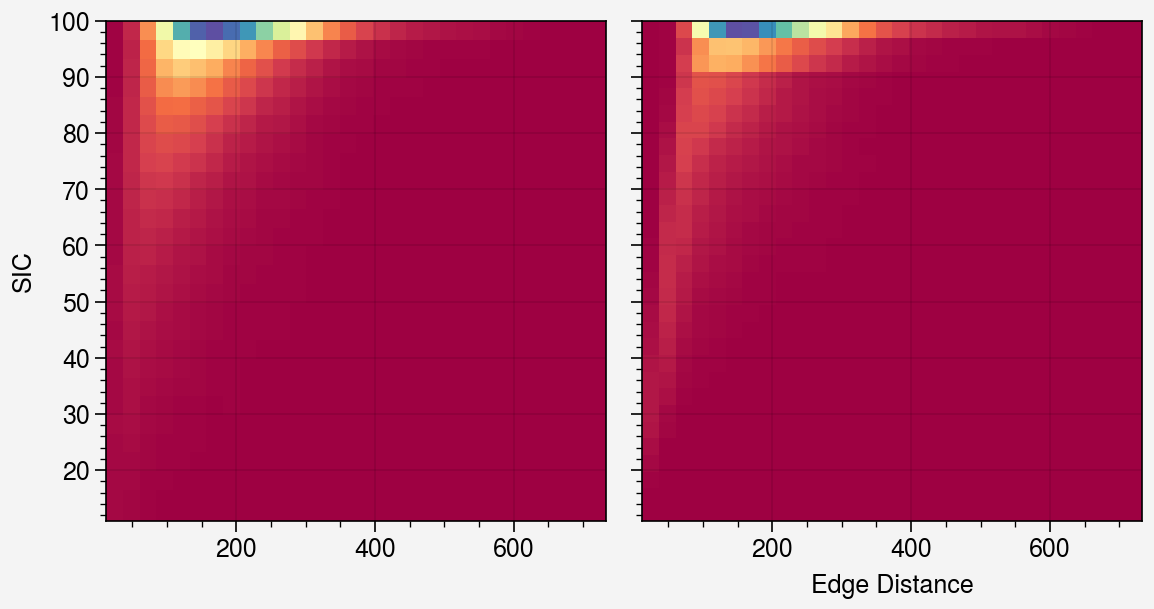

In [119]:
import ultraplot as uplt
fig, axs = uplt.subplots(ncols=2)
ax = axs[0]
ax.hist2d(df.edge_dist_km, df.asi_sic_mean.where(df.nsidc_sic.notnull()), bins=[30, 30], cmap='spectral')

ax = axs[1]
ax.hist2d(df.edge_dist_km, df.nsidc_sic * 100,  bins=[30, 30], cmap='spectral');
ax.format(ylabel='SIC', xlabel='Edge Distance')

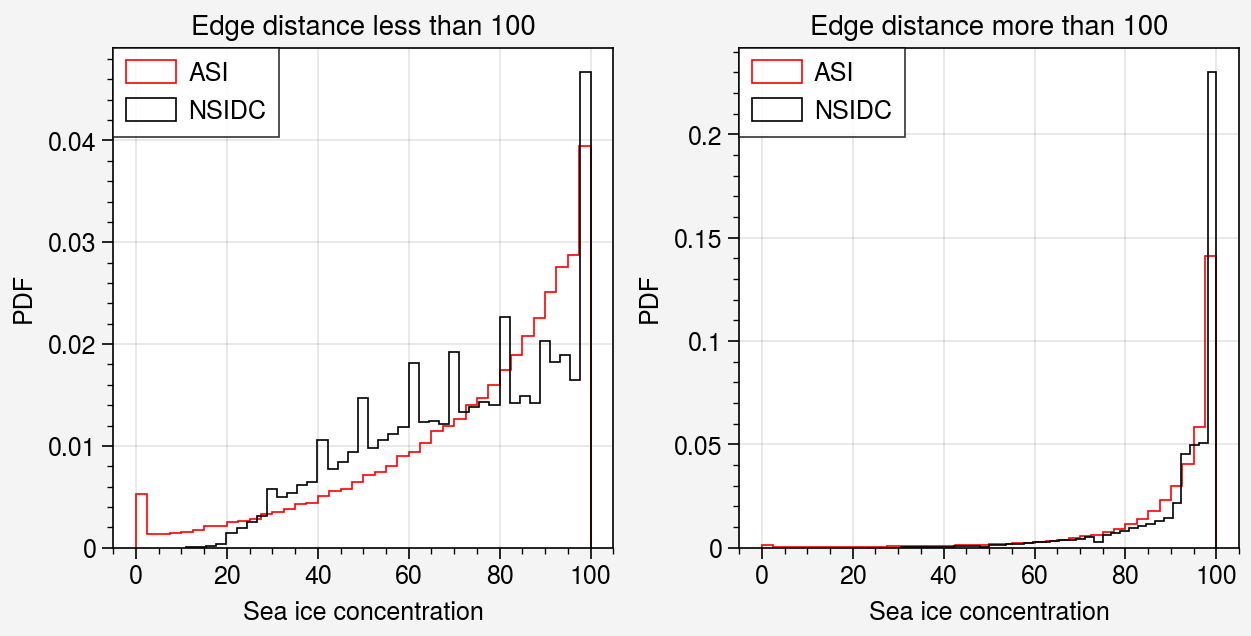

In [120]:
import ultraplot as uplt
fig, axs = uplt.subplots(ncols=2, share=False)
ax = axs[0]
ax.hist(df.asi_sic_mean.where(df.edge_dist_km < 100).dropna(), bins=40, color='r', histtype='step', label='ASI', density=True)
ax.hist((df.nsidc_sic * 100).where(df.edge_dist_km < 100).dropna(),  bins=40, color='k', histtype='step', label='NSIDC', density=True);
ax.format(ylabel='PDF', xlabel='Sea ice concentration', title='Edge distance less than 100')
ax.legend(loc='ul', ncols=1)

ax = axs[1]
ax.hist(df.asi_sic_mean.where(df.edge_dist_km > 100).dropna(), bins=40, color='r', histtype='step', label='ASI', density=True)
ax.hist((df.nsidc_sic * 100).where(df.edge_dist_km > 100).dropna(),  bins=40, color='k', histtype='step', label='NSIDC', density=True);
ax.format(ylabel='PDF', xlabel='Sea ice concentration', title='Edge distance more than 100')
ax.legend(loc='ul', ncols=1)

<a list of 1 Line2D objects>

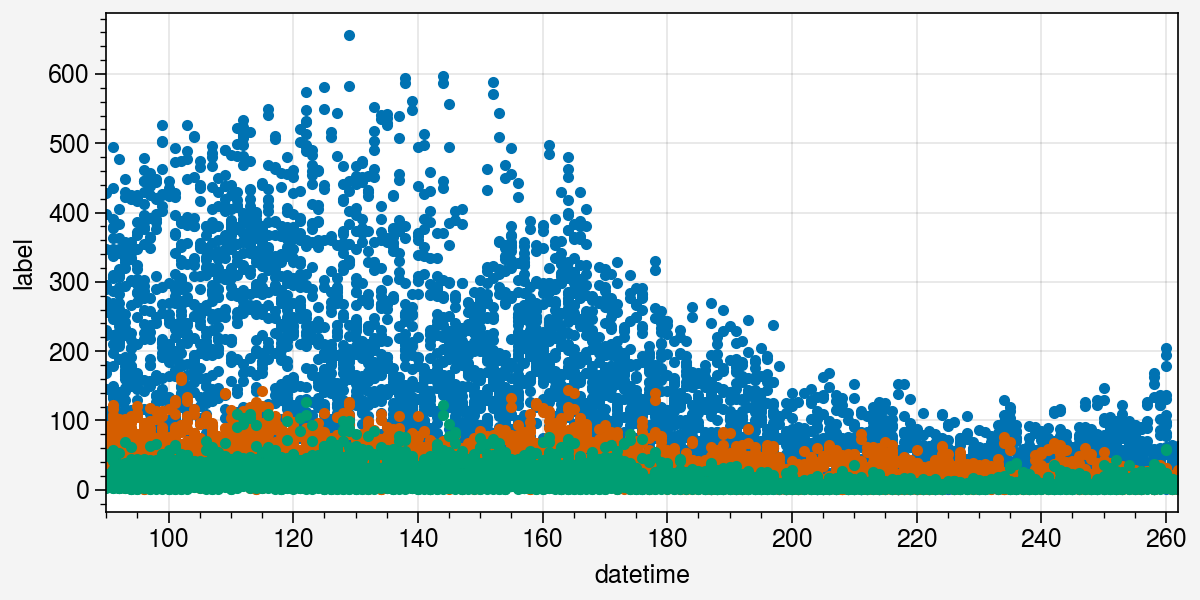

In [121]:
fig, ax = uplt.subplots(width=6, height=3)
ax.plot(all_areas.index.dayofyear, all_areas, marker='.', lw=0, label='all')
ax.plot(near_edge_areas.index.dayofyear, near_edge_areas, marker='.', lw=0, label='edge')
ax.plot(far_edge_areas.index.dayofyear, far_edge_areas, marker='.', lw=0, label='interior')

In [179]:
miz_areas.groupby(miz_areas.index.dayofyear).count()

datetime
90     22
91     31
92     33
93     31
94     33
       ..
258    23
259    24
260    23
261    25
262    20
Name: label, Length: 173, dtype: int64

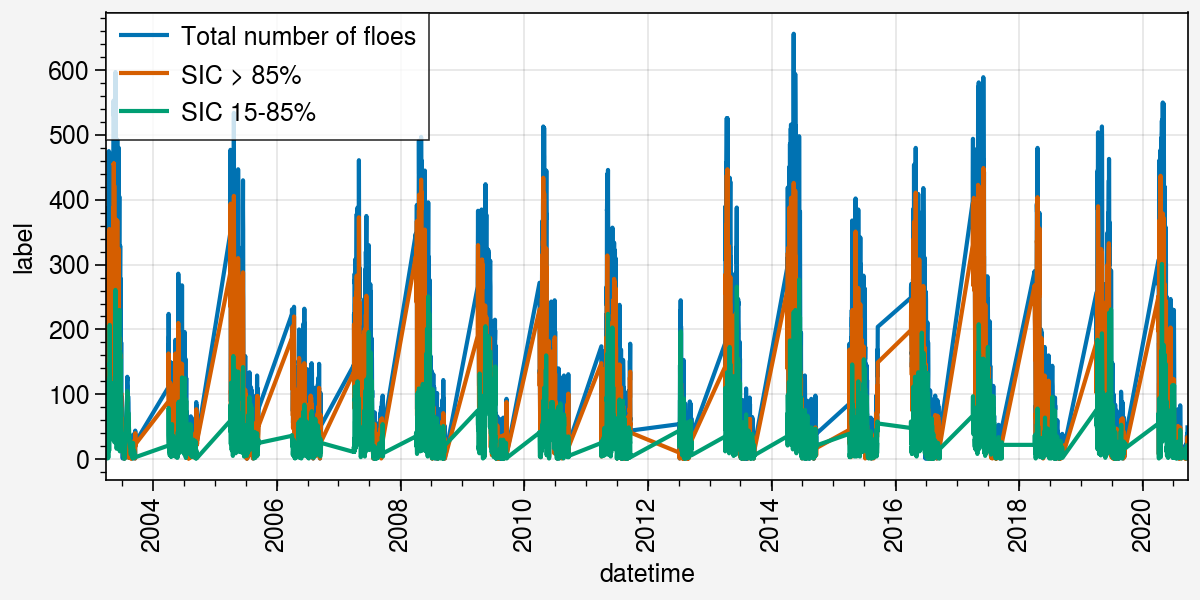

In [122]:
all_areas = df.loc[df.final_classification].groupby('datetime').count()['label']
pack_ice_areas = df.loc[df.final_classification & df.asi_sic_mean.between(85, 100)].groupby('datetime').count()['label']
miz_areas = df.loc[df.final_classification & df.asi_sic_mean.between(1, 85)].groupby('datetime').count()['label']
fig, ax = uplt.subplots(width=6, height=3)
ax.plot(all_areas, label='Total number of floes')
ax.plot(pack_ice_areas, label='SIC > 85%')
ax.plot(miz_areas, label='SIC 15-85%')
ax.legend(ncols=1)

For the analysis of the FSD in MIZ vs the pack ice, we select the date with the maximum for each week (month?) to include for the comparison.

In [124]:
max_counts = miz_areas.resample('7d').max()
max_counts = max_counts[max_counts.index.month != 3]

dt = pd.to_timedelta('7d')
date_select = []
for date in max_counts.index:
    subset = miz_areas.loc[slice(date-dt, date)]
    if len(subset) > 0:
        date_select.append(subset.idxmax())

In [125]:
df_weekly_maxima = df.loc[df.final_classification].groupby('datetime').filter(lambda x: x.name in date_select)

In [195]:
if maximum(df_weekly_maxima['nsidc_sic']) < 50:
    df_weekly_maxima['nsidc_sic'] *= 100

In [ ]:
fig, axs = uplt.subplots(width=9, ncols=3, spanx=False)
xmax=90000
months = {4: 'April', 5: 'May', 6: 'June', 7: 'July'}
results = []
for ax, month in zip(axs, [4, 5, 6, 7]):
    # SIC < 0.8 
    df_subset = df_weekly_maxima.loc[(df_weekly_maxima.datetime.dt.month == month) & df_weekly_maxima.nsidc_sic.between(1, 85)]
    for year, group in df_subset.groupby(df_subset.datetime.dt.year):
        data = group.area*0.25*0.25
        fit = powerlaw.Fit(data, xmin=35, xmax=xmax)
        fit.plot_pdf(color='slateblue', linewidth=0.7, ax=ax, label='', alpha=0.3)
        fit.plot_ccdf(color='slateblue', linewidth=0.7, ax=ax, alpha=0.3)
        results.append(['miz', 'weekly', year, df_subset.datetime.min(), fit.truncated_power_law.alpha])
    data = df_subset.area*0.25*0.25
    fit = powerlaw.Fit(data,xmin=35, xmax=xmax)
    fit.plot_pdf(color='slateblue', linewidth=2, ax=ax, label='SIC 15-85%')
    fit.plot_ccdf(color='slateblue', linewidth=2, ax=ax)
    results.append(['miz', 'monthly', year, df_subset.datetime.min(), fit.truncated_power_law.alpha])
    # SIC > 0.8
    df_subset = df_weekly_maxima.loc[(df_weekly_maxima.datetime.dt.month == month) & df_weekly_maxima.nsidc_sic.between(85, 100)]
    for year, group in df_subset.groupby(df_subset.datetime.dt.year):
        data = group.area * 0.25*0.25
        fit = powerlaw.Fit(data,xmin=35, xmax=xmax)
        fit.plot_pdf(color='green', linewidth=0.7, ax=ax, label='', alpha=0.3, ls='--')
        fit.plot_ccdf(color='green', linewidth=0.7, ax=ax, alpha=0.3, ls='--')
        results.append(['pack', 'weekly', year, df_subset.datetime.min(), fit.truncated_power_law.alpha])
    data = df_subset.area*0.25*0.25
    fit = powerlaw.Fit(data,xmin=35, xmax=xmax)
    fit.plot_pdf(color='green', linewidth=2, ax=ax, label='SIC > 85%', ls='--')
    fit.plot_ccdf(color='green', linewidth=2, ax=ax, ls='--')
    results.append(['pack', 'monthly', year, df_subset.datetime.min(), fit.truncated_power_law.alpha])
    ax.format(xlabel='Floe area (km$^2$)', ylabel='Probability', fontsize=12, title=months[month], suptitle='Pack vs miz using NSIDC CDR')
axs[0].legend(loc='lr', ncols=1)   

/opt/miniconda3/envs/ift_jog/lib/python3.13/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/opt/miniconda3/envs/ift_jog/lib/python3.13/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/opt/miniconda3/envs/ift_jog/lib/python3.13/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/opt/miniconda3/envs/ift_jog/lib/python3.13/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/opt/miniconda3/envs/ift_jog/lib/python3.13/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/opt/miniconda3/envs/ift_jog/lib/python3.13/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


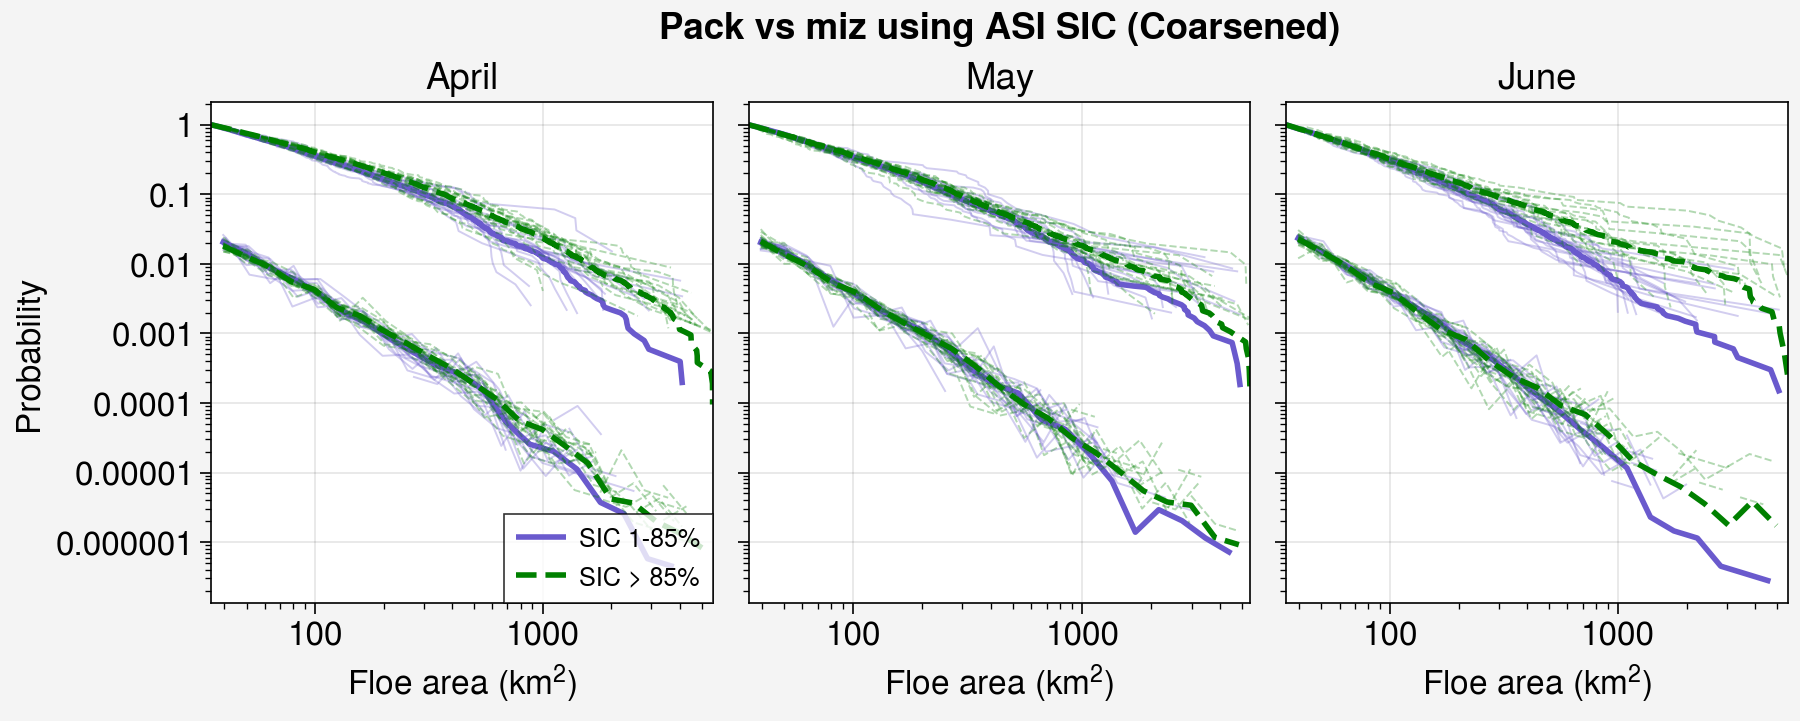

In [199]:
fig, axs = uplt.subplots(width=9, ncols=3, spanx=False)
xmax=90000
months = {4: 'April', 5: 'May', 6: 'June', 7: 'July'}
results = []
for ax, month in zip(axs, [4, 5, 6, 7]):
    # SIC < 0.8 
    df_subset = df_weekly_maxima.loc[(df_weekly_maxima.datetime.dt.month == month) & df_weekly_maxima.asi_sic_mean_coarsened.between(1, 85)]
    for year, group in df_subset.groupby(df_subset.datetime.dt.year):
        data = group.area*0.25*0.25
        fit = powerlaw.Fit(data, xmin=35, xmax=xmax)
        fit.plot_pdf(color='slateblue', linewidth=0.7, ax=ax, label='', alpha=0.3)
        fit.plot_ccdf(color='slateblue', linewidth=0.7, ax=ax, alpha=0.3)
        results.append(['miz', 'weekly', year, df_subset.datetime.min(), fit.truncated_power_law.alpha])
    data = df_subset.area*0.25*0.25
    fit = powerlaw.Fit(data,xmin=35, xmax=xmax)
    fit.plot_pdf(color='slateblue', linewidth=2, ax=ax, label='SIC 1-85%')
    fit.plot_ccdf(color='slateblue', linewidth=2, ax=ax)
    results.append(['miz', 'monthly', year, df_subset.datetime.min(), fit.truncated_power_law.alpha])
    # SIC > 0.8
    df_subset = df_weekly_maxima.loc[(df_weekly_maxima.datetime.dt.month == month) & df_weekly_maxima.asi_sic_mean_coarsened.between(85, 100)]
    for year, group in df_subset.groupby(df_subset.datetime.dt.year):
        data = group.area * 0.25*0.25
        fit = powerlaw.Fit(data,xmin=35, xmax=xmax)
        fit.plot_pdf(color='green', linewidth=0.7, ax=ax, label='', alpha=0.3, ls='--')
        fit.plot_ccdf(color='green', linewidth=0.7, ax=ax, alpha=0.3, ls='--')
        results.append(['pack', 'weekly', year, df_subset.datetime.min(), fit.truncated_power_law.alpha])
    data = df_subset.area*0.25*0.25
    fit = powerlaw.Fit(data,xmin=35, xmax=xmax)
    fit.plot_pdf(color='green', linewidth=2, ax=ax, label='SIC > 85%', ls='--')
    fit.plot_ccdf(color='green', linewidth=2, ax=ax, ls='--')
    results.append(['pack', 'monthly', year, df_subset.datetime.min(), fit.truncated_power_law.alpha])
    ax.format(xlabel='Floe area (km$^2$)', ylabel='Probability', fontsize=12, title=months[month], suptitle='Pack vs miz using ASI SIC (Coarsened)')
axs[0].legend(loc='lr', ncols=1)   

In [188]:
df_weekly_maxima.loc[(df_weekly_maxima.datetime.dt.month == month) & df_weekly_maxima.nsidc_sic.between(85, 100)]

Empty DataFrame
Columns: [Unnamed: 0, datetime, satellite, floe_id, label, longitude, latitude, x_stere, y_stere, col_pixel, row_pixel, area, perimeter, solidity, orientation, circularity, axis_major_length, axis_minor_length, bbox_min_row, bbox_min_col, bbox_max_row, bbox_max_col, area_matlab, perimeter_matlab, solidity_matlab, orientation_matlab, nsidc_sic, theta_aqua, theta_terra, tc_channel0, tc_channel1, tc_channel2, fc_channel0, fc_channel1, fc_channel2, init_classification, lr_probability, lr_classification, final_classification, edge_dist_km, coast_dist_km, date, asi_sic_mean, asi_sic_std, area_expanded, perimeter_expanded, asi_sic_mean_coarsened]
Index: []

[0 rows x 47 columns]

In [191]:
df_weekly_maxima.loc[(df_weekly_maxima.datetime.dt.month == month), 'nsidc_sic']

261       0.92
262       0.74
263       0.60
264       0.94
265       0.69
          ... 
695475    0.97
695476    1.00
695477    1.00
695478    1.00
695479    1.00
Name: nsidc_sic, Length: 25553, dtype: float64

In [132]:
results.columns = ['region', 'timescale', 'year', 'week_start_date', 'alpha_tpl']

<a list of 1 Line2D objects>

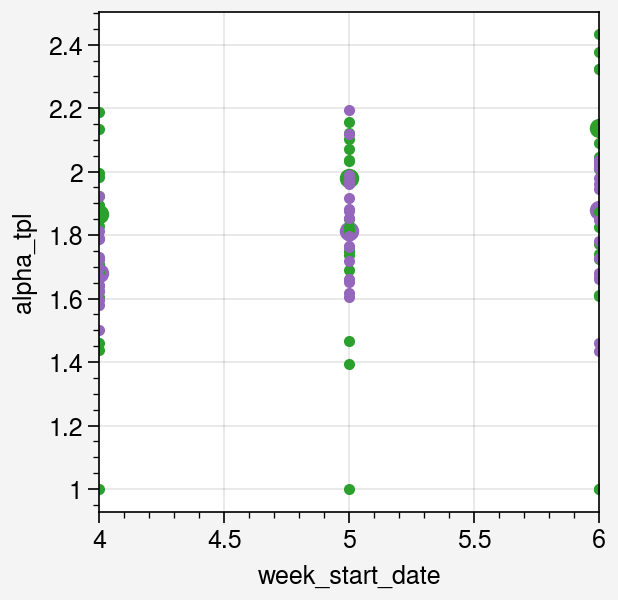

In [140]:
fig, ax = pplt.subplots()
miz_month = results.loc[(results.region=='miz') & (results.timescale=='monthly')]
pack_month = results.loc[(results.region=='pack') & (results.timescale=='monthly')]
ax.plot(miz_month.week_start_date.dt.month, miz_month.alpha_tpl, color='tab:green', marker='o', lw=0)
ax.plot(pack_month.week_start_date.dt.month, pack_month.alpha_tpl, color='tab:purple', marker='o', lw=0)

miz_week = results.loc[(results.region=='miz') & (results.timescale=='weekly')]
pack_week = results.loc[(results.region=='pack') & (results.timescale=='weekly')]
ax.plot(miz_week.week_start_date.dt.month, miz_week.alpha_tpl, color='tab:green', marker='.', lw=0)
ax.plot(pack_week.week_start_date.dt.month, pack_week.alpha_tpl, color='tab:purple', marker='.', lw=0)

In [168]:
pack_week['month'] = pack_week.week_start_date.dt.month

/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_70311/2076699893.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pack_week['month'] = pack_week.week_start_date.dt.month


{'whiskers': <a list of 6 Line2D objects>,
 'caps': <a list of 6 Line2D objects>,
 'boxes': <a list of 3 Line2D objects>,
 'medians': <a list of 3 Line2D objects>,
 'fliers': <a list of 3 Line2D objects>,
 'means': []}

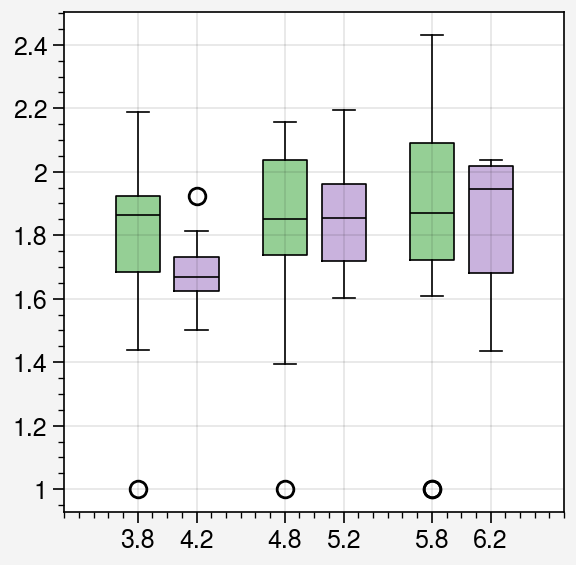

In [181]:
fig, ax = uplt.subplots()
ax.box(pd.DataFrame({3.8: miz_week.loc[miz_week.month==4,'alpha_tpl'].values,
 4.8: miz_week.loc[miz_week.month==5,'alpha_tpl'].values,
 5.8: miz_week.loc[miz_week.month==6,'alpha_tpl'].values}), facecolor='tab:green', alpha=0.5)
ax.box(pd.DataFrame({4.2: pack_week.loc[pack_week.month==4,'alpha_tpl'].values,
 5.2: pack_week.loc[pack_week.month==5,'alpha_tpl'].values,
 6.2: pack_week.loc[pack_week.month==6,'alpha_tpl'].values}), facecolor='tab:purple', alpha=0.5)

In [174]:
results.loc[results.timescale=='monthly']

region timescale  year     week_start_date  alpha_tpl
17     miz   monthly  2020 2003-04-01 13:31:49   1.865957
35    pack   monthly  2020 2003-04-01 13:31:49   1.680857
53     miz   monthly  2020 2003-05-11 14:20:13   1.980666
71    pack   monthly  2020 2003-05-11 14:20:13   1.812109
89     miz   monthly  2020 2003-06-04 12:10:09   2.136685
107   pack   monthly  2020 2003-06-04 12:10:09   1.877586